# Analisis Data Penyimpangan antara Realisasi dan Rencana Produksi

In [1]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 11.4 MB/s eta 0:00:00


In [2]:
# Data manipulation
import pandas as pd
import numpy as np
import regex as re
from collections import defaultdict

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import shap

#Hypotesis Testing
from scipy.stats import kstest, mannwhitneyu, chi2_contingency, f_oneway, pearsonr, spearmanr
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#Data Preprocessing
from sklearn.preprocessing import OneHotEncoder, RobustScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer,TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, SelectFwe, f_regression

#Model Selection
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Algorithm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR

#Model Evaluation
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

# Import Data

In [3]:
data_produksi = pd.read_excel("Data Produksi.xlsx")
data_spk_biaya = pd.read_excel("spk biaya 2024.xlsx",sheet_name="Data")
data_spk_durasi = pd.read_excel("spk durasi 2024.xlsx",sheet_name="Data")
data_speed_mesin = pd.read_excel("speed mesin.xlsx")

In [4]:
df1 = data_produksi.copy()
df2 = data_spk_biaya.copy()
df3 = data_spk_durasi.copy().rename(columns={"MESIN":"NAMA MESIN"})
df4 = data_speed_mesin.copy()

In [5]:
df1.head()

CABANG                                     NO PRODUKSI  \
0  PT. TMG - SBY  SBY-PRD-04/24-0180 -- FINISHING - POTONG COVER   
1  PT. TMG - SBY       SBY-PRD-04/24-0163 -- CETAK - CETAK SHEET   
2  PT. TMG - SBY       SBY-PRD-04/24-0163 -- CETAK - CETAK SHEET   
3  PT. TMG - SBY       SBY-PRD-04/24-0163 -- CETAK - CETAK SHEET   
4  PT. TMG - SBY       SBY-PRD-04/24-0163 -- CETAK - CETAK SHEET   

                                                 SPK    TANGGAL  OPLAH MEDIA  \
0  0002/SPK/04-24 / 1 -- JAYABAYA -- 33 - MINGGU ... 2024-04-03       1925.0   
1  0002/SPK/04-24 / 1 -- JAYABAYA -- 33 - MINGGU ... 2024-04-03       1925.0   
2  0002/SPK/04-24 / 1 -- JAYABAYA -- 33 - MINGGU ... 2024-04-03       1925.0   
3  0002/SPK/04-24 / 1 -- JAYABAYA -- 33 - MINGGU ... 2024-04-03       1925.0   
4  0002/SPK/04-24 / 1 -- JAYABAYA -- 33 - MINGGU ... 2024-04-03       1925.0   

   HASIL CETAK KONFIGURASI  JML WEB  JML WEB GROSS CETAK VEL / KATERN  ...  \
0       2100.0         NaN      NaN                    0          NaN  ...   
1        575.0         4/4      1.0                    0           CB  ...   
2        575.0         4/4      1.0                    0           CB  ...   
3        575.0         4/4      1.0                    0           CB  ...   
4        575.0         4/4      1.0                    0           CB  ...   

  WASTE KUPASAN BAHAN                   NAMA MESIN    PRESETTING START  \
0                 0.0                      ITOTECH 2024-04-03 05:00:00   
1                 0.0  Sheet Line 2 (Komori LG440) 2024-04-02 23:30:00   
2                 0.0  Sheet Line 2 (Komori LG440) 2024-04-02 23:30:00   
3                 0.0  Sheet Line 2 (Komori LG440) 2024-04-02 23:30:00   
4                 0.0  Sheet Line 2 (Komori LG440) 2024-04-02 23:30:00   

       PRESETTING END         START MESIN        ENDING MESIN  DURASI MESIN  \
0 2024-04-03 05:04:00 2024-04-03 05:04:00 2024-04-03 05:38:00            38   
1 2024-04-02 23:35:00 2024-04-02 23:35:00 2024-04-02 23:59:00            29   
2 2024-04-02 23:35:00 2024-04-02 23:35:00 2024-04-02 23:59:00            29   
3 2024-04-02 23:35:00 2024-04-02 23:35:00 2024-04-02 23:59:00            29   
4 2024-04-02 23:35:00 2024-04-02 23:35:00 2024-04-02 23:59:00            29   

  LAMA TROUBLE DURASI EFEKTIF  \
0            0             38   
1            0             29   
2            0             29   
3            0             29   
4            0             29   

                                          KETERANGAN  
0                                                NaN  
1  23:30\t23:45\tTUNGGU CETAKAN AGAK KERING \nJOY...  
2  23:30\t23:45\tTUNGGU CETAKAN AGAK KERING \nJOY...  
3  23:30\t23:45\tTUNGGU CETAKAN AGAK KERING \nJOY...  
4  23:30\t23:45\tTUNGGU CETAKAN AGAK KERING \nJOY...  

[5 rows x 26 columns]

In [6]:
df2.head()

Bulan                  SPK                    MEDIA           KATEGORI  \
0  Januari  SPK: 0001/SPK/01-24  Sahabat -- Januari 2023  Majalah Komersial   
1  Januari  SPK: 0001/SPK/01-24  Sahabat -- Januari 2023  Majalah Komersial   
2  Januari  SPK: 0001/SPK/01-24  Sahabat -- Januari 2023  Majalah Komersial   
3  Januari  SPK: 0001/SPK/01-24  Sahabat -- Januari 2023  Majalah Komersial   
4  Januari  SPK: 0001/SPK/01-24  Sahabat -- Januari 2023  Majalah Komersial   

            KOMPONEN UNIT          MKT        PPIC     REAL       RP MKT  \
0              Tinta   Kg     0.000000    35.32000    25.10         0.00   
1             Kertas  Rim    35.500000    34.90000    32.66  18490376.06   
2                Hpp  Pcs  4133.101008  3613.19925  3502.44  33064808.06   
3  Pendukung_Lainnya   Kg     0.000000    11.30000     0.00         0.00   
4           Overhead  Jam     0.000000    22.90000     6.80         0.00   

        RP PPIC       RP REAL               Customer  
0  2.555402e+06  1.822966e+06  Yayasan Lagzis Peduli  
1  1.692425e+07  1.741613e+07  Yayasan Lagzis Peduli  
2  2.890559e+07  2.801952e+07  Yayasan Lagzis Peduli  
3  5.318500e+05  0.000000e+00  Yayasan Lagzis Peduli  
4  7.693503e+06  1.016939e+06  Yayasan Lagzis Peduli

In [7]:
df3.head()

Bulan                                                SPK  \
0  April  Media: 0002/SPK/04-24 / 1 (Jayabaya -- 33 - Mi...   
1  April  Media: 0002/SPK/04-24 / 1 (Jayabaya -- 33 - Mi...   
2  April  Media: 0002/SPK/04-24 / 1 (Jayabaya -- 33 - Mi...   
3  April  Media: 0002/SPK/04-24 / 1 (Jayabaya -- 33 - Mi...   
4  April  Media: 0002/SPK/04-24 / 1 (Jayabaya -- 33 - Mi...   

                                   NAMA MESIN  QTY MK  QTY PI  QTY REAL  \
0               Agfa Screen - Screen R 8600-S       0    0.20  0.000000   
1                  Itotech - Potong Satu Sisi       0    0.20  0.566667   
2                   Muller Presto - Stitching       0    0.70  0.000000   
3                Osako (Muller3) - Stiching 3       0    0.00  1.500000   
4  Sheet Line 2 (Komori Lg440) - Sheet Line 2       0    0.25  0.000000   

   AMOUNT MK    AMOUNT PI  AMOUNT REAL  
0          0   20737.9440        0.000  
1          0   22928.4300    64963.885  
2          0  180334.4830        0.000  
3          0       0.0000   232911.555  
4          0  149824.2825        0.000

#Cleaning Data


- Nama Mesin  
Disesuaikan antara data produksi dan data performa  

- SPK  
Menyesuaikan kode SPK antara data produksi dan target

- Tanggal Mulai dan Tanggal Selesai  
Tanggal mulai dan tanggal selesai harus dalam bulan yang sama  

- Durasi Downtime, Efektif  
Durasi harus lebih dari 0 dan kurang dari 744 dan perhitungan total durasi harus dikelompokkan berdasarkan no produksi

- Total Cetak  
Seusaikan antara hasil cetak dari data dengan max speed kali durasi  

- Nilai Tidak Konsisten  
Ada mesin yang sama namun memiliki nilai yang berbeda

- Nilai Kosong  
Nilai kosong memang ada yang kosong dan tidak boleh diisi dan ada nilai kosong yang nilainya dalam satu nomer produksi atau satu SPK

- Tandai data yang ada keslahan

## Nama Mesin

In [8]:
#Nama Mesin

mesin_pracetak = {"AGFA SCREEN":"AGFA SCREEN - SCREEN R 8600-S",
                  "TRENDSETTER Kodak TS 2":"TRENDSETTER KODAK TS 2 - CTP 4",
                  "Trendsetter Kodak XD TS 1":"TRENDSETTER KODAK XD TS 1 - CTP 3",
                  "SCREEN N2000 -S I":"SCREEN N2000 -S I - CTP 1",
                  "SCREEN N2000 S 2":"SCREEN N2000 S 2 - CTP 2"}

mesin_cetaksheet = {"Sheet Line 2 (Komori LG440)":"SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2",
                    "Sheet Line 1 (Komori LS440)":"SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1",
                    "KOMORI LINTHRONE S 440 P":"SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1",
                    "CETAK SHEET HEIDELBERG DRUCK":"CETAK SHEET HEIDELBERG DRUCK - MASCHINEN AKTIENGESELISCHAFT",
                    "HEIDEL BERG SM 102":"CETAK SHEET HEIDELBERG DRUCK - MASCHINEN AKTIENGESELISCHAFT"}

mesin_cetakweb = {"Web Line 6 (Universal 630)":"WEB LINE 6 (UNIVERSAL 630) - WEB LINE 6",
                  "Web Line 1 (Uniset 60 )":"WEB LINE 1 (UNISET 60 ) - WEB - 3C,3C,3C,FOLDER,4H,5RS - SWDC - 4/4,4/2,2/1 - 60.000/CPH - 7 JAM",
                  "Universal":"UNIVERSAL - WEB LINE 3- 4H,4H,FOLDER,4H",
                  "Universal 63 - ex bks":"WEB LINE 6 (UNIVERSAL 630) - WEB LINE 6",
                  "WEB SOLNA Cut Off 546 02 (BARU)":"WEB SOLNA CUT OFF 546 02 (BARU) - TMG SBY 2023",
                  "Web Line 2 (Uniset 60)":"WEB LINE 2 (UNISET 60) - WEB LINE 2,4H,3C,4H,FOLDER,4H,4H",
                  "WEB TENSOR CUT OFF 63-DEPA":"WEB TENSOR CUT OFF 63-DEPA - PERLINTASAN RP14,-1/1",
                  "WEB SOLNA Cut Off 546 01 (SECOND)":"WEB SOLNA CUT OFF 546 01 (SECOND) - TMG SBY 2023",
                  "GLOBAL WEB 630 LINE 7":"GLOBAL WEB 630 LINE 7 - CUTT OFF 630 4/4"}

mesin_finishing = {
"CASE IN EX BOOK PRODUCTION LINE" : "CASE IN EX BOOK PRODUCTION LINE - KOLBUS BF 512, SN :144",
"CASE MAKER KOLBUS DA260" : "CASE MAKER KOLBUS DA260 - 2010 GERMANY",
"COLLATOR 24 FEEDER 2011" : "COLLATOR 24 FEEDER 2011 - SPRINTER E, SN : 151",
"MESIN SEWING ASTER EVO 1" : "MESIN SEWING ASTER EVO 1 - BARU",
"Muller 1" : "MULLER PRESTO - STITCHING",
"MULLER PRESTO" : "MULLER PRESTO - STITCHING",
"NEW YOSHINO VEGA" : "NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN",
"Osako (muller3)" : "OSAKO (MULLER3) - STICHING 3",
"SIDEBLAD (END SHEET) EX BOOK PRODUC LINE" : "SIDEBLAD (END SHEET) EX BOOK PRODUC LINE - SIGLOCH BBL-3 1/2 SN 28-057",
"TRIMMER EX BOOK PRODUCTION LINE" : "TRIMMER EX BOOK PRODUCTION LINE - KOLBUS HD 130, SN : 83",
"YOSHINO" : "NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN"}

In [9]:
mesin_pakai = [
"AGFA SCREEN - SCREEN R 8600-S",
"CASE IN EX BOOK PRODUCTION LINE - KOLBUS BF 512, SN :144",
"CASE MAKER KOLBUS DA260 - 2010 GERMANY",
"CETAK SHEET HEIDELBERG DRUCK - MASCHINEN AKTIENGESELISCHAFT",
"COLLATOR 24 FEEDER 2011 - SPRINTER E, SN : 151",
"GLOBAL WEB 630 LINE 7 - CUTT OFF 630 4/4",
"MESIN SEWING ASTER EVO 1 - BARU",
"MULLER PRESTO - STITCHING",
"NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN",
"OSAKO (MULLER3) - STICHING 3",
"SCREEN N2000 S 2 - CTP 2",
"SCREEN N2000 -S I - CTP 1",
"SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1",
"SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2",
"SIDEBLAD (END SHEET) EX BOOK PRODUC LINE - SIGLOCH BBL-3 1/2 SN 28-057",
"TRENDSETTER KODAK TS 2 - CTP 4",
"TRENDSETTER KODAK XD TS 1 - CTP 3",
"TRIMMER EX BOOK PRODUCTION LINE - KOLBUS HD 130, SN : 83",
"UNIVERSAL - WEB LINE 3- 4H,4H,FOLDER,4H",
"WEB LINE 1 (UNISET 60 ) - WEB - 3C,3C,3C,FOLDER,4H,5RS - SWDC - 4/4,4/2,2/1 - 60.000/CPH - 7 JAM",
"WEB LINE 2 (UNISET 60) - WEB LINE 2,4H,3C,4H,FOLDER,4H,4H",
"WEB LINE 6 (UNIVERSAL 630) - WEB LINE 6",
"WEB SOLNA CUT OFF 546 01 (SECOND) - TMG SBY 2023",
"WEB SOLNA CUT OFF 546 02 (BARU) - TMG SBY 2023",
"WEB TENSOR CUT OFF 63-DEPA - PERLINTASAN RP14,-1/1"
]

In [10]:
df1['MESIN'] = df1['NAMA MESIN']
df1["MESIN"] = df1["MESIN"].replace(mesin_pracetak)
df1["MESIN"] = df1["MESIN"].replace(mesin_cetaksheet)
df1["MESIN"] = df1["MESIN"].replace(mesin_cetakweb)
df1["MESIN"] = df1["MESIN"].replace(mesin_finishing)
df1 = df1.loc[df1['MESIN']!=df1["NAMA MESIN"],:]
pd.DataFrame(df1['MESIN'].value_counts().sort_values()).sort_values('MESIN')

count
MESIN                                                    
AGFA SCREEN - SCREEN R 8600-S                        2059
CASE IN EX BOOK PRODUCTION LINE - KOLBUS BF 512...    140
CASE MAKER KOLBUS DA260 - 2010 GERMANY                 78
CETAK SHEET HEIDELBERG DRUCK - MASCHINEN AKTIEN...     71
COLLATOR 24 FEEDER 2011 - SPRINTER E, SN : 151         92
GLOBAL WEB 630 LINE 7 - CUTT OFF 630 4/4              250
MESIN SEWING ASTER EVO 1 - BARU                       195
MULLER PRESTO - STITCHING                             647
NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN           835
OSAKO (MULLER3) - STICHING 3                          227
SCREEN N2000 -S I - CTP 1                             184
SCREEN N2000 S 2 - CTP 2                               17
SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1           4000
SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2           8043
SIDEBLAD (END SHEET) EX BOOK PRODUC LINE - SIGL...     38
TRENDSETTER KODAK TS 2 - CTP 4                       3693
TRENDSETTER KODAK XD TS 1 - CTP 3                    1398
TRIMMER EX BOOK PRODUCTION LINE - KOLBUS HD 130...    111
UNIVERSAL - WEB LINE 3- 4H,4H,FOLDER,4H              9026
WEB LINE 1 (UNISET 60 ) - WEB - 3C,3C,3C,FOLDER...   4834
WEB LINE 2 (UNISET 60) - WEB LINE 2,4H,3C,4H,FO...   4398
WEB LINE 6 (UNIVERSAL 630) - WEB LINE 6               463
WEB SOLNA CUT OFF 546 01 (SECOND) - TMG SBY 2023     3334
WEB SOLNA CUT OFF 546 02 (BARU) - TMG SBY 2023       8724
WEB TENSOR CUT OFF 63-DEPA - PERLINTASAN RP14,-1/1   4386

In [11]:
df3['MESIN'] = df3['NAMA MESIN']
df3["MESIN"] = df3["MESIN"].replace(mesin_pracetak)
df3["MESIN"] = df3["MESIN"].replace(mesin_cetaksheet)
df3["MESIN"] = df3["MESIN"].replace(mesin_cetakweb)
df3["MESIN"] = df3["MESIN"].replace(mesin_finishing)
df3["MESIN"] = df3["MESIN"].apply(lambda x:x.upper())
# df3 = df3.loc[df3['MESIN']!=df3["NAMA MESIN"],:]
pd.DataFrame(df3['MESIN'].value_counts().sort_values()).sort_values('MESIN')

count
MESIN                                                    
AGFA SCREEN - SCREEN R 8600-S                        1591
ANGLE CUTTER - POTONG HARDCOVER KARTON 1               72
CARD BOARD CUTTING - POTONG HARDCOVER KARTON 2         26
CASE IN EX BOOK PRODUCTION LINE - KOLBUS BF 512...     87
CASE MAKER KOLBUS DA260 - 2010 GERMANY                 78
CETAK SHEET HEIDELBERG DRUCK - MASCHINEN AKTIEN...     45
COLLATOR 24 FEEDER 2011 - SPRINTER E, SN : 151         69
DE-BOSS 002                                             2
GLOBAL WEB 630 LINE 7 - CUTT OFF 630 4/4              109
HEIDEL BERG SM 102 - HEIDEL BERG SM 102, SHEET ...      2
HOTPRINT  TYMK 001 - MELIWIS                            5
ISHIDA- SEWING KECIL                                    1
ITOH 1 - POTONG KERTAS 1                               40
ITOH 2 - POTONG KERTAS 2                                6
ITOTECH - POTONG SATU SISI                            939
LAMINASI PAM WL 900 - LAMINASI PAM                    244
LAMINASI UV                                           464
LIPAT STAHL 001 - EX ATNG                              89
LIPAT STAHL 002 - WAHYU DHARMA PERKASA                115
MESIN LIPAT RATAN NO. 1 - TMG SBY                       6
MESIN SEWING ASTER EVO 1 - BARU                        82
MINIPACK ODULAR 50 - MINIPACK UDULAR 50               266
MULLER PRESTO - STITCHING                             366
NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN           503
OSAKO (MULLER3) - STICHING 3                           61
POLAR ,POTONG KERTAS 3 - TIDAK ADA D SUMENGKO           1
POTONG PLANO WOHLENBERG 1 SISI                         37
SABLON MANUAL                                           2
SCREEN 20001-CTP 1                                      1
SCREEN N2000 -S I - CTP 1                             199
SCREEN N2000 S 2 - CTP 2                               15
SEWING MULLER MARTINI - SEWING                          1
SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1            277
SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2           1037
SIDEBLAD (END SHEET) EX BOOK PRODUC LINE - SIGL...     48
SPIN CUTTER - POTONG TRIPLEX                           73
STRAPPING                                              37
TAECHANG - HOT PRINT                                    4
TRENDSETTER KODAK TS 2 - CTP 4                       2608
TRENDSETTER KODAK XD TS 1 - CTP 3                    1121
TRIMMER EX BOOK PRODUCTION LINE - KOLBUS HD 130...     42
TSK - BINDING 3                                        32
TSK - POTONG 3 SISI 3                                  45
TSK, BINDING 5 - BINDING TSK                           11
UNIVERSAL - WEB LINE 3- 4H,4H,FOLDER,4H              1141
UNIVERSAL 63 - EX BKS                                  41
UV CHI FENG - TMG SBY                                   4
VENTURA - SEWING BESAR                                  3
WEB LINE 1 (UNISET 60 ) - WEB - 3C,3C,3C,FOLDER...    932
WEB LINE 2 (UNISET 60) - WEB LINE 2,4H,3C,4H,FO...    122
WEB LINE 6 (UNIVERSAL 630) - WEB LINE 6                82
WEB SOLNA CUT OFF 546 01 (SECOND) - TMG SBY 2023      305
WEB SOLNA CUT OFF 546 02 (BARU) - TMG SBY 2023        997
WEB TENSOR CUT OFF 63-DEPA - PERLINTASAN RP14,-1/1    285

In [12]:
df1 = df1.loc[df1['MESIN'].isin(mesin_pakai),:]
df3 = df3.loc[df3['MESIN'].isin(mesin_pakai),:]

In [13]:
df1['MESIN'].nunique()

25

In [14]:
df3['MESIN'].nunique()

25

## No SPK

In [15]:
df1["NO SPK"] = df1["SPK"].apply(lambda x:x.split()[0]+x.split()[1]+x.split()[2])
df1["NO SPK"]

1        0002/SPK/04-24/1
2        0002/SPK/04-24/1
3        0002/SPK/04-24/1
4        0002/SPK/04-24/1
5        0002/SPK/04-24/1
               ...       
68848             DUMMY/0
68849             DUMMY/0
68850             DUMMY/0
68851             DUMMY/0
68852             DUMMY/0
Name: NO SPK, Length: 57243, dtype: object

In [16]:
df2["NO SPK"] = df2["SPK"].apply(lambda x:x.split()[1])
df2["NO SPK"]

0        0001/SPK/01-24
1        0001/SPK/01-24
2        0001/SPK/01-24
3        0001/SPK/01-24
4        0001/SPK/01-24
              ...      
33701    0657/SPK/06-24
33702    0657/SPK/06-24
33703    0657/SPK/06-24
33704    0657/SPK/06-24
33705    0657/SPK/06-24
Name: NO SPK, Length: 33706, dtype: object

In [17]:
df3["NO SPK"] = df3["SPK"].apply(lambda x:x.split()[1]+x.split()[2]+x.split()[3])
df3["NO SPK"]

0        0002/SPK/04-24/1
2        0002/SPK/04-24/1
3        0002/SPK/04-24/1
4        0002/SPK/04-24/1
5        0002/SPK/04-24/1
               ...       
14766    0657/SPK/06-24/1
14767    0657/SPK/06-24/1
14768    0657/SPK/06-24/1
14769    0657/SPK/06-24/1
14770    0657/SPK/06-24/1
Name: NO SPK, Length: 12202, dtype: object

## Menggabungkan Data

In [18]:
ket = df2.groupby("NO SPK")[["MEDIA","KATEGORI","Customer"]].first().reset_index()
ket.head()

NO SPK                                              MEDIA  \
0  0001/SPK/01-24                            Sahabat -- Januari 2023   
1  0001/SPK/02-24               Yasin 2 Warna -- 128 Ap 100gr - Gold   
2  0001/SPK/03-24                                      Materi Sholat   
3  0001/SPK/05-24                 Kamus Indonesia Dan Inggris -- 996   
4  0001/SPK/06-24  My Next Words Grade 3 - Student’S Book For Ele...   

                  KATEGORI                             Customer  
0        Majalah Komersial                Yayasan Lagzis Peduli  
1     Penunjang Kitab Suci                          Abdul Malik  
2       Bk Penerbit Swasta           Jepe Press Media Utama, Pt  
3       Bk Penerbit Swasta           Jepe Press Media Utama, Pt  
4  Kurmer Het Baru Agst 23  Temprina Media Grafika Surabaya, Pt

In [19]:
df = pd.DataFrame()
df = df1.merge(df3,on=["NO SPK", "MESIN"],how="inner").drop(columns=["SPK_x","SPK_y","NAMA MESIN_x","NAMA MESIN_y"])
df["SPK"] = df["NO SPK"].apply(lambda x:x[:len(x)-2])
df = df.merge(ket,left_on=["SPK"],right_on=["NO SPK"],how="inner")
df = df.drop(columns=["NO SPK_y","CABANG","KONFIGURASI","JML WEB","JML WEB GROSS CETAK","VEL / KATERN","KETERANGAN"]).rename(columns={"NO SPK_x":"NO SPK"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51831 entries, 0 to 51830
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   NO PRODUKSI          51831 non-null  object        
 1   TANGGAL              51831 non-null  datetime64[ns]
 2   OPLAH MEDIA          51831 non-null  float64       
 3   HASIL CETAK          44953 non-null  float64       
 4   SHIFF                44953 non-null  object        
 5   JENIS BAHAN          50201 non-null  object        
 6   NAMA BAHAN           50201 non-null  object        
 7   QTY BAHAN            50201 non-null  float64       
 8   WASTE BAHAN          51831 non-null  float64       
 9   WASTE CORE BAHAN     51831 non-null  float64       
 10  WASTE KUPASAN BAHAN  51831 non-null  float64       
 11  PRESETTING START     44953 non-null  datetime64[ns]
 12  PRESETTING END       44953 non-null  datetime64[ns]
 13  START MESIN          51831 non-

In [20]:
len(df)

51831

## Duplikat Data

In [21]:
index_duplikat = df.loc[df.drop(columns=['NO PRODUKSI',"SPK",'NO SPK']).duplicated(),:].index
df.drop(columns=['NO PRODUKSI',"SPK",'NO SPK']).duplicated().sum()

288

In [22]:
duplikat = df.loc[df.drop(columns=['NO PRODUKSI',"SPK",'NO SPK']).duplicated()]
df = df.drop(index_duplikat)
duplikat

NO PRODUKSI    TANGGAL  \
3121   SBY-PRD-02/24-1188 -- FINISHING - BINDING KOMPLIT 2024-02-26   
3122   SBY-PRD-02/24-1188 -- FINISHING - BINDING KOMPLIT 2024-02-26   
3123   SBY-PRD-02/24-1188 -- FINISHING - BINDING KOMPLIT 2024-02-26   
3124   SBY-PRD-02/24-1188 -- FINISHING - BINDING KOMPLIT 2024-02-26   
4454                   SBY-PRD-03/24-0600 -- PRA CETAK - 2024-03-19   
...                                                  ...        ...   
51225            SBY-PRD-05/24-1704 -- CETAK - CETAK WEB 2024-05-28   
51226            SBY-PRD-05/24-1704 -- CETAK - CETAK WEB 2024-05-28   
51227            SBY-PRD-05/24-1704 -- CETAK - CETAK WEB 2024-05-28   
51228            SBY-PRD-05/24-1704 -- CETAK - CETAK WEB 2024-05-28   
51229            SBY-PRD-05/24-1704 -- CETAK - CETAK WEB 2024-05-28   

       OPLAH MEDIA  HASIL CETAK  SHIFF        JENIS BAHAN  \
3121       69541.0       5200.0  SIANG  PENDUKUNG PACKING   
3122       69541.0       5200.0  SIANG  PENDUKUNG PACKING   
3123       69541.0       5200.0  SIANG  PENDUKUNG PACKING   
3124       69541.0       5200.0  SIANG  PENDUKUNG PACKING   
4454      100000.0          NaN    NaN              PLATE   
...            ...          ...    ...                ...   
51225       2073.0       2173.0  MALAM              TINTA   
51226       2073.0       2173.0  MALAM             KERTAS   
51227       2073.0       2173.0  MALAM              TINTA   
51228       2073.0       2173.0  MALAM              TINTA   
51229       2073.0       2173.0  MALAM              TINTA   

                                              NAMA BAHAN   QTY BAHAN  \
3121               KARDUS SINGLE WALL -- 36 X 26 X 25 CM  163.000000   
3122               KARDUS SINGLE WALL -- 36 X 26 X 25 CM  163.000000   
3123               KARDUS SINGLE WALL -- 36 X 26 X 25 CM  163.000000   
3124               KARDUS SINGLE WALL -- 36 X 26 X 25 CM  163.000000   
4454   PLATE CTP THERMAL HUIDA -- 1030 X 800 X 0.3 HUIDA    9.000000   
...                                                  ...         ...   
51225        TINTA YELLOW CEMANI -- TOKA BW NEWS PR CS-N    0.370950   
51226  KERTAS ROLL CD BIASA PRIMA ADIPRIMA -- 45 GR 6...   84.000000   
51227         TINTA BLACK CEMANI -- TOKA BW NEWS PR CS-N    0.840820   
51228          TINTA CYAN CEMANI -- TOKA BW NEWS PR CS-N    0.333855   
51229       TINTA MAGENTA CEMANI -- TOKA BW NEWS PR CS-N    0.296760   

       WASTE BAHAN  WASTE CORE BAHAN  ...  QTY MK QTY PI  QTY REAL AMOUNT MK  \
3121           0.0               0.0  ...       0    0.0  2.333333         0   
3122           0.0               0.0  ...       0    0.0  2.333333         0   
3123           0.0               0.0  ...       0    0.0  2.333333         0   
3124           0.0               0.0  ...       0    0.0  2.333333         0   
4454           0.0               0.0  ...       0    0.8  0.000000         0   
...            ...               ...  ...     ...    ...       ...       ...   
51225          0.0               0.0  ...       0    0.0  0.333333         0   
51226         10.0               0.0  ...       0    0.0  0.333333         0   
51227          0.0               0.0  ...       0    0.0  0.333333         0   
51228          0.0               0.0  ...       0    0.0  0.333333         0   
51229          0.0               0.0  ...       0    0.0  0.333333         0   

       AMOUNT PI    AMOUNT REAL             SPK  \
3121       0.000  653310.653333  0170/SPK/02-24   
3122       0.000  653310.653333  0170/SPK/02-24   
3123       0.000  653310.653333  0170/SPK/02-24   
3124       0.000  653310.653333  0170/SPK/02-24   
4454   82951.776       0.000000  0220/SPK/03-24   
...          ...            ...             ...   
51225      0.000  233167.000000  0500/SPK/05-24   
51226      0.000  233167.000000  0500/SPK/05-24   
51227      0.000  233167.000000  0500/SPK/05-24   
51228      0.000  233167.000000  0500/SPK/05-24   
51229      0.000  233167.000000  0500/SPK/05-24   

                    

## Missing Data

In [23]:
pd.DataFrame(df.isna().sum(),columns=["Jumlah Missing"]).loc[df.isna().sum()>0]

Jumlah Missing
HASIL CETAK                 6728
SHIFF                       6728
JENIS BAHAN                 1628
NAMA BAHAN                  1628
QTY BAHAN                   1628
PRESETTING START            6728
PRESETTING END              6728

In [24]:
missing_row = df.isnull().any(axis = 1).sum()
missing_row

8356

In [25]:
len(df)

51543

In [26]:
(missing_row*100/len(df)).round(2)

16.21

## Tanggal

### Presetting Start & End

Beda Bulan

In [27]:
index_tanggal = df.loc[(df['PRESETTING START'].dt.month!=df['PRESETTING END'].dt.month)&(df['PRESETTING START'].isna()==False),:].index
df["Salah Tanggal"] = 0
df.loc[index_tanggal,["Salah Tanggal"]] = 1
df.loc[(df['PRESETTING START'].dt.month!=df['PRESETTING END'].dt.month)&(df['PRESETTING START'].isna()==False),:].shape

(1, 32)

In [28]:
df.loc[(df['PRESETTING START'].dt.month!=df['PRESETTING END'].dt.month)&(df['PRESETTING START'].isna()==False),["TANGGAL","PRESETTING START","PRESETTING END"]]

TANGGAL    PRESETTING START      PRESETTING END
36385 2024-06-07 2024-06-06 23:30:00 2024-07-06 01:45:00

In [29]:
df.loc[(df['PRESETTING START'].dt.month!=df['PRESETTING END'].dt.month)&(df['PRESETTING START'].isna()==False),'PRESETTING END'] = df.loc[(df['PRESETTING START'].dt.month!=df['PRESETTING END'].dt.month)&(df['PRESETTING START'].isna()==False),'PRESETTING END'] - pd.Timedelta(days=29)
df.loc[(df['PRESETTING START'].dt.month!=df['PRESETTING END'].dt.month)&(df['PRESETTING START'].isna()==False),:].shape

(0, 32)

Belum Ganti Hari

In [30]:
index_tanggal = df.loc[(df['PRESETTING START']>df['PRESETTING END'])&(df['PRESETTING START'].isna()==False),:].index
df.loc[index_tanggal,["Salah Tanggal"]] = 1
df.loc[(df['PRESETTING START']>df['PRESETTING END'])&(df['PRESETTING START'].isna()==False),:].shape

(0, 32)

In [31]:
df.loc[(df['PRESETTING START']>df['PRESETTING END'])&(df['PRESETTING START'].isna()==False),["TANGGAL","PRESETTING START","PRESETTING END"]]

Empty DataFrame
Columns: [TANGGAL, PRESETTING START, PRESETTING END]
Index: []

In [32]:
df.loc[(df['PRESETTING START']>df['PRESETTING END'])&(df['PRESETTING START'].isna()==False),["PRESETTING END"]] = df.loc[(df['PRESETTING START']>df['PRESETTING END'])&(df['PRESETTING START'].isna()==False),["PRESETTING END"]] + pd.Timedelta(days=1)
df.loc[(df['PRESETTING START']>df['PRESETTING END'])&(df['PRESETTING START'].isna()==False),:].shape

(0, 32)

### Start dan Ending Mesin

Beda Bulan

In [33]:
index_tanggal = df.loc[(df['START MESIN'].dt.month!=df['ENDING MESIN'].dt.month),:].index
df.loc[index_tanggal,["Salah Tanggal"]] = 1
df.loc[(df['START MESIN'].dt.month!=df['ENDING MESIN'].dt.month),:].shape

(0, 32)

In [34]:
df.loc[(df['START MESIN'].dt.month!=df['ENDING MESIN'].dt.month),["TANGGAL","START MESIN","ENDING MESIN"]].head()

Empty DataFrame
Columns: [TANGGAL, START MESIN, ENDING MESIN]
Index: []

In [35]:
df.loc[(df['START MESIN'].dt.month!=df['ENDING MESIN'].dt.month),'ENDING MESIN'] = df.loc[(df['START MESIN'].dt.month!=df['ENDING MESIN'].dt.month),'ENDING MESIN'] - pd.Timedelta(days=29)
df.loc[(df['START MESIN'].dt.month!=df['ENDING MESIN'].dt.month),:].shape

(0, 32)

Belum Ganti Hari

In [36]:
index_tanggal = df.loc[(df['START MESIN']>df['ENDING MESIN']),:].index
df.loc[index_tanggal,["Salah Tanggal"]] = 1
df.loc[(df['START MESIN']>df['ENDING MESIN']),:].shape

(0, 32)

In [37]:
df.loc[(df['START MESIN']>df['ENDING MESIN']),["TANGGAL","START MESIN","ENDING MESIN"]]

Empty DataFrame
Columns: [TANGGAL, START MESIN, ENDING MESIN]
Index: []

In [38]:
df.loc[(df['START MESIN']>df['ENDING MESIN']),["ENDING MESIN"]] = df.loc[(df['START MESIN']>df['ENDING MESIN']),["ENDING MESIN"]] + pd.Timedelta(days=1)
df.loc[(df['START MESIN']>df['ENDING MESIN']),:].shape

(0, 32)

## Durasi Efektif

In [39]:
df.loc[df['DURASI MESIN']>40000,:].shape

(1, 32)

In [40]:
df.loc[df['DURASI MESIN']<0,:].shape

(0, 32)

### Durasi Mesin

In [41]:
#Menghitung durasi setting mesin
df['DURASI SETTING HIT'] = df['PRESETTING END'] - df['PRESETTING START']
df['DURASI SETTING HIT'] = df['DURASI SETTING HIT'].dt.total_seconds()/60
df['DURASI SETTING HIT'] = df['DURASI SETTING HIT'].fillna(0)

#Menghitung durasi kerja mesin
df['DURASI MESIN HIT'] = df['ENDING MESIN'] - df['START MESIN']
df['DURASI MESIN HIT'] = df['DURASI MESIN HIT'].dt.total_seconds()/60

#Menghitung total durasi mesin
df['DURASI TOTAL HIT'] = df['DURASI SETTING HIT'] + df['DURASI MESIN HIT']
# data.head()

In [42]:
print("Kesalahan pada durasi setting :",df.loc[df['DURASI SETTING HIT']<0,:].shape)
print("Kesalahan pada durasi mesin :",df.loc[df['DURASI MESIN HIT']<0,:].shape)


Kesalahan pada durasi setting : (0, 35)
Kesalahan pada durasi mesin : (0, 35)


### Lama Trouble

Lama Trouble Negatif

In [43]:
index_trouble = df.loc[df["LAMA TROUBLE"]<0,:].index
df["Salah Trouble"] = 0
df.loc[index_trouble,["Salah Trouble"]] = 1
df.loc[df["LAMA TROUBLE"]<0,:].shape

(44, 36)

In [44]:
df.loc[df["LAMA TROUBLE"]<0,["TANGGAL","MESIN","LAMA TROUBLE"]].head()

TANGGAL                                              MESIN  \
15666 2024-02-19  WEB LINE 1 (UNISET 60 ) - WEB - 3C,3C,3C,FOLDE...   
15667 2024-02-19  WEB LINE 1 (UNISET 60 ) - WEB - 3C,3C,3C,FOLDE...   
15668 2024-02-19  WEB LINE 1 (UNISET 60 ) - WEB - 3C,3C,3C,FOLDE...   
15669 2024-02-19  WEB LINE 1 (UNISET 60 ) - WEB - 3C,3C,3C,FOLDE...   
15670 2024-02-19  WEB LINE 1 (UNISET 60 ) - WEB - 3C,3C,3C,FOLDE...   

       LAMA TROUBLE  
15666           -30  
15667           -30  
15668           -30  
15669           -30  
15670           -30

In [45]:
#Untuk sementara dirubah menjadi 0
df.loc[df["LAMA TROUBLE"]<0,"LAMA TROUBLE"] = 0

Lama Trouble Lebih Lama daripada Durasi Mesin

In [46]:
index_trouble = df.loc[df["LAMA TROUBLE"]>df['DURASI MESIN HIT'],:].index
df.loc[index_trouble,["Salah Trouble"]] = 1
df.loc[df["LAMA TROUBLE"]>df['DURASI MESIN HIT'],:].shape

(1063, 36)

In [47]:
df.loc[df["LAMA TROUBLE"]>df['DURASI MESIN HIT'],["TANGGAL","MESIN","DURASI MESIN HIT", "LAMA TROUBLE"]].head()

TANGGAL                                              MESIN  \
19 2024-04-02  WEB TENSOR CUT OFF 63-DEPA - PERLINTASAN RP14,...   
20 2024-04-02  WEB TENSOR CUT OFF 63-DEPA - PERLINTASAN RP14,...   
21 2024-04-02  WEB TENSOR CUT OFF 63-DEPA - PERLINTASAN RP14,...   
22 2024-04-02  WEB TENSOR CUT OFF 63-DEPA - PERLINTASAN RP14,...   
23 2024-04-02  WEB TENSOR CUT OFF 63-DEPA - PERLINTASAN RP14,...   

    DURASI MESIN HIT  LAMA TROUBLE  
19              60.0            65  
20              60.0            65  
21              60.0            65  
22              60.0            65  
23              60.0            65

In [48]:
#Untuk sementara dirubah menjadi 0
df.loc[df["LAMA TROUBLE"]>df['DURASI MESIN HIT'],"LAMA TROUBLE"] = 0

### Durasi Efektif

In [49]:
df['DURASI EFEKTIF HIT'] = df['DURASI TOTAL HIT'] - df['LAMA TROUBLE']
df.loc[df['DURASI EFEKTIF HIT']>4000,:].shape

(10, 37)

In [50]:
df.loc[df['DURASI EFEKTIF HIT']<0,:].shape

(0, 37)

# Variabel Predictor

## Tanggal

In [51]:
tanggal = df.groupby(["NO SPK","MESIN"])["TANGGAL"].first().reset_index()
tanggal

NO SPK                                        MESIN    TANGGAL
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S 2024-01-04
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN 2024-01-06
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2 2024-01-06
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S 2024-02-07
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN 2024-02-13
...                ...                                          ...        ...
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1 2024-01-04
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1 2024-01-04
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1 2024-01-04
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S 2024-01-01
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4 2024-01-16

[9002 rows x 3 columns]

## Oplah Media

In [52]:
oplah = df.groupby(["NO SPK","MESIN"])["OPLAH MEDIA"].mean().reset_index()
oplah

NO SPK                                        MESIN  \
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S   
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2   
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
...                ...                                          ...   
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S   
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4   

      OPLAH MEDIA  
0          8000.0  
1          8000.0  
2          8000.0  
3         50000.0  
4         50000.0  
...           ...  
8997       1179.0  
8998        831.0  
8999        747.0  
9000       3525.0  
9001       3525.0  

[9002 rows x 3 columns]

## Hasil Cetak

In [53]:
hasil = df.groupby(["NO SPK","MESIN"])["HASIL CETAK"].mean().reset_index()
hasil['HASIL CETAK'] = hasil['HASIL CETAK'].fillna(0).round(0)
hasil

NO SPK                                        MESIN  \
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S   
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2   
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
...                ...                                          ...   
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S   
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4   

      HASIL CETAK  
0             0.0  
1          8072.0  
2          6990.0  
3             0.0  
4         12530.0  
...           ...  
8997      11360.0  
8998      11360.0  
8999      11360.0  
9000          0.0  
9001          0.0  

[9002 rows x 3 columns]

In [54]:
# Untuk Mesin PRACETAK
bahan = df.groupby(['NO SPK','MESIN'])['QTY BAHAN'].mean().reset_index()
bahan['QTY BAHAN'] = bahan['QTY BAHAN'].fillna(0).round(0)
hasil['HASIL CETAK'] = hasil['HASIL CETAK'] + bahan["QTY BAHAN"]
hasil

NO SPK                                        MESIN  \
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S   
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2   
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
...                ...                                          ...   
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S   
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4   

      HASIL CETAK  
0            18.0  
1          8072.0  
2          6991.0  
3             7.0  
4         12539.0  
...           ...  
8997      11371.0  
8998      11371.0  
8999      11371.0  
9000         20.0  
9001          4.0  

[9002 rows x 3 columns]

## Shift Cetak

In [55]:
shift = df.groupby(["NO SPK","MESIN"])["SHIFF"].first().reset_index()
shift

NO SPK                                        MESIN  SHIFF
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S   None
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN  SIANG
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2  SIANG
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   None
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   SORE
...                ...                                          ...    ...
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1  SIANG
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1  SIANG
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1  SIANG
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S   None
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4   None

[9002 rows x 3 columns]

In [56]:
groups = shift.groupby(["NO SPK"])

all_na = groups['SHIFF'].transform(lambda x: x.isna().all())

shift.loc[all_na, 'SHIFF'] = shift['SHIFF'].mode()[0]

mode_by_group = groups['SHIFF'].transform(lambda x: x.mode()[0])
shift['SHIFF'] = shift['SHIFF'].fillna(mode_by_group)
shift

NO SPK                                        MESIN  SHIFF
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S  SIANG
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN  SIANG
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2  SIANG
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   SORE
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   SORE
...                ...                                          ...    ...
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1  SIANG
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1  SIANG
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1  SIANG
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S  MALAM
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4  MALAM

[9002 rows x 3 columns]

## Jumlah Penggunaan Mesin

In [57]:
penggunaan = df.groupby(["NO SPK","MESIN"])["NO PRODUKSI"].nunique().rename("JUMLAH PENGGUNAAN").reset_index()
penggunaan

NO SPK                                        MESIN  \
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S   
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2   
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
...                ...                                          ...   
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S   
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4   

      JUMLAH PENGGUNAAN  
0                     2  
1                     1  
2                    10  
3                     3  
4                     2  
...                 ...  
8997                  1  
8998                  1  
8999                  1  
9000                  2  
9001                  1  

[9002 rows x 3 columns]

## Jumlah Jeda Mesin

## Rata-Rata Lama Jeda

## Jumlah Bahan

In [58]:
jumlah_bahan = df.groupby(["NO SPK","MESIN"])["QTY BAHAN"].sum().reset_index()
jumlah_bahan

NO SPK                                        MESIN  QTY BAHAN
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S      36.00
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN       0.00
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2      60.00
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S      21.00
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN       9.00
...                ...                                          ...        ...
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1      22.82
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1      22.82
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1      22.82
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S      40.00
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4       4.00

[9002 rows x 3 columns]

## Merk Bahan

## Durasi Setting

In [59]:
setting = df.groupby(["NO SPK","MESIN","NO PRODUKSI"])["DURASI SETTING HIT"].mean().reset_index()
setting = setting.groupby(["NO SPK","MESIN"])["DURASI SETTING HIT"].sum().reset_index()
setting["DURASI SETTING HIT"] = setting["DURASI SETTING HIT"].apply(lambda x:x/60).round(2)
setting

NO SPK                                        MESIN  \
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S   
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2   
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
...                ...                                          ...   
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S   
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4   

      DURASI SETTING HIT  
0                   0.00  
1                   0.48  
2                   3.03  
3                   0.00  
4                   0.73  
...                  ...  
8997                0.03  
8998                0.03  
8999                0.03  
9000                0.00  
9001                0.00  

[9002 rows x 3 columns]

## Durasi Mesin

In [60]:
dmesin = df.groupby(["NO SPK","MESIN","NO PRODUKSI"])["DURASI MESIN HIT"].mean().reset_index()
dmesin = dmesin.groupby(["NO SPK","MESIN"])["DURASI MESIN HIT"].sum().reset_index()
dmesin["DURASI MESIN HIT"] = dmesin["DURASI MESIN HIT"].apply(lambda x:x/60).round(2)
dmesin

NO SPK                                        MESIN  \
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S   
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2   
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
...                ...                                          ...   
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S   
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4   

      DURASI MESIN HIT  
0                 1.80  
1                 1.75  
2                 8.38  
3                 1.05  
4                 7.92  
...                ...  
8997              0.43  
8998              0.43  
8999              0.43  
9000              2.00  
9001              0.17  

[9002 rows x 3 columns]

## Ada Trouble

In [61]:
df["TROUBLE"] = df["LAMA TROUBLE"].apply(lambda x:1 if x>0 else 0)
ada_t = df.groupby(["NO SPK","MESIN"])["TROUBLE"].sum().reset_index()
ada_t["TROUBLE"] = ada_t["TROUBLE"].apply(lambda x:"Ada" if x>0 else "Tidak Ada")
ada_t

NO SPK                                        MESIN    TROUBLE
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S  Tidak Ada
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN  Tidak Ada
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2  Tidak Ada
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S  Tidak Ada
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN  Tidak Ada
...                ...                                          ...        ...
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1  Tidak Ada
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1  Tidak Ada
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1  Tidak Ada
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S  Tidak Ada
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4  Tidak Ada

[9002 rows x 3 columns]

## Lama Trouble

In [62]:
trouble = df.groupby(["NO SPK","MESIN","NO PRODUKSI"])["LAMA TROUBLE"].mean().reset_index()
trouble = trouble.groupby(["NO SPK","MESIN"])["LAMA TROUBLE"].sum().reset_index()
trouble["LAMA TROUBLE"] = trouble["LAMA TROUBLE"].apply(lambda x: x/60)
trouble

NO SPK                                        MESIN  \
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S   
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2   
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
...                ...                                          ...   
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S   
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4   

      LAMA TROUBLE  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
...            ...  
8997           0.0  
8998           0.0  
8999           0.0  
9000           0.0  
9001           0.0  

[9002 rows x 3 columns]

In [63]:
trouble["LAMA TROUBLE"].max()

35.016666666666666

## Ada Waste

In [64]:
df["WASTE"] = df["WASTE BAHAN"].apply(lambda x:1 if x>0 else 0) + df["WASTE CORE BAHAN"].apply(lambda x:1 if x>0 else 0) + df["WASTE KUPASAN BAHAN"].apply(lambda x:1 if x>0 else 0)
if_waste = df.groupby(["NO SPK","MESIN"])["WASTE"].sum().reset_index()
if_waste["WASTE"] = if_waste["WASTE"].apply(lambda x:"Ada" if x>0 else "Tidak Ada")
if_waste

NO SPK                                        MESIN      WASTE
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S  Tidak Ada
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN  Tidak Ada
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2  Tidak Ada
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S  Tidak Ada
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN  Tidak Ada
...                ...                                          ...        ...
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1        Ada
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1        Ada
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1        Ada
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S  Tidak Ada
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4  Tidak Ada

[9002 rows x 3 columns]

## Jumlah Waste

In [65]:
waste = df.groupby(["NO SPK","MESIN"])["WASTE"].sum() + df.groupby(["NO SPK","MESIN"])["WASTE CORE BAHAN"].sum() + df.groupby(["NO SPK","MESIN"])["WASTE KUPASAN BAHAN"].sum()
waste = waste.rename("JML WASTE").reset_index()
waste

NO SPK                                        MESIN  JML WASTE
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S        0.0
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN        0.0
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2        0.0
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S        0.0
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN        0.0
...                ...                                          ...        ...
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1        1.0
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1        1.0
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1        1.0
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S        0.0
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4        0.0

[9002 rows x 3 columns]

## Kategori Cetak

In [66]:
pracetak = list(mesin_pracetak.values())
cetaksheet = list(mesin_cetaksheet.values())
cetakweb = list(mesin_cetakweb.values())
finishing = list(mesin_finishing.values())
def kat_mesin (x):
  if x in pracetak:
    return "Pracetak"
  elif x in cetaksheet:
    return "Cetak Sheet"
  elif x in cetakweb:
    return "Cetak Web"
  elif x in finishing:
    return "Finishing"

In [67]:
df["KAT_MESIN"] = df["MESIN"].apply(kat_mesin)
kategori_mesin = df.groupby(["NO SPK","MESIN"])["KAT_MESIN"].first().reset_index()
kategori_mesin

NO SPK                                        MESIN  \
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S   
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2   
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
...                ...                                          ...   
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S   
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4   

        KAT_MESIN  
0        Pracetak  
1       Finishing  
2     Cetak Sheet  
3        Pracetak  
4       Finishing  
...           ...  
8997  Cetak Sheet  
8998  Cetak Sheet  
8999  Cetak Sheet  
9000     Pracetak  
9001     Pracetak  

[9002 rows x 3 columns]

## Kategori Cetakan

In [68]:
kategori = df.groupby(["NO SPK","MESIN"])["KATEGORI"].first().reset_index()
kategori

NO SPK                                        MESIN  \
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S   
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2   
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
...                ...                                          ...   
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S   
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4   

                     KATEGORI  
0           Majalah Komersial  
1           Majalah Komersial  
2           Majalah Komersial  
3        Penunjang Kitab Suci  
4        Penunjang Kitab Suci  
...                       ...  
8997  Proyek Surat Suara 2024  
8998  Proyek Surat Suara 2024  
8999  Proyek Surat Suara 2024  
9000  Proyek Surat Suara 2024  
9001  Proyek Surat Suara 2024  

[9002 rows x 3 columns]

In [69]:
def cetakan (x):
  x = x.lower().split()
  if "koran" in x:
    return "koran"
  elif ("surat" in x) and ("suara" in x):
    return "surat suara"
  elif  ("majalah" in x) or ("Tabloid" in x) or ("brosur" in x) or ("packaging" in x) or ("kalender" in x) or ("digital" in x):
    return "percetakan komersial"
  elif "kitab" in x:
    return "kitab suci"
  else:
    return "buku"

In [70]:
kategori["KATEGORI"] = kategori["KATEGORI"].apply(cetakan)
kategori["KATEGORI"].value_counts()

KATEGORI
koran                   5059
buku                    2672
surat suara              678
percetakan komersial     350
kitab suci               243
Name: count, dtype: int64

## Customer

In [71]:
df["Customer"].value_counts().head()

Customer
Jawa Pos Radar, Pt                      10166
Jepe Press Media Utama, Pt               7247
Temprina Media Grafika Surabaya, Pt      5029
Temprina Media Grafika  Semarang, Pt     4407
Jawa Pos Koran, Pt                       3027
Name: count, dtype: int64

In [72]:
def customer (cust):
  x = cust.lower().split()
  if ("pt" in x) or ("cv" in x):
    c = "Perusahaan"
    if ("jawa" in x) and ("pos" in x):
      c = "Jawa Pos"
    elif ("temprina" in x):
      c = "Internal Temprina"
  elif "komisi" in x or "kpu" in x:
    c = "Instansi Pemerintahan"
  elif ("badan" in x) or ("universitas" in x) or ("unisma" in x):
    c = "Instansi Pendidikan"
  elif ("koperasi" in x) or ("yayasan" in x):
    c = "Instansi Lain"
  else:
    c = "Perorangan"
  return c

In [73]:
df["CUSTOMER"] = df["Customer"].apply(customer)
df["CUSTOMER"].value_counts()

CUSTOMER
Perusahaan               16029
Jawa Pos                 13193
Internal Temprina         9478
Perorangan                7289
Instansi Pemerintahan     2790
Instansi Pendidikan       2268
Instansi Lain              496
Name: count, dtype: int64

In [74]:
tipe_customer = df.groupby(["NO SPK","MESIN"])["CUSTOMER"].first().reset_index()
tipe_customer

NO SPK                                        MESIN  \
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S   
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2   
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
...                ...                                          ...   
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S   
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4   

                   CUSTOMER  
0             Instansi Lain  
1             Instansi Lain  
2             Instansi Lain  
3                Perorangan  
4                Perorangan  
...                     ...  
8997  Instansi Pemerintahan  
8998  Instansi Pemerintahan  
8999  Instansi Pemerintahan  
9000  Instansi Pemerintahan  
9001  Instansi Pemerintahan  

[9002 rows x 3 columns]

# Variable Response

## Penyimpangan durasi produksi

In [75]:
durasi_produksi = df.groupby(["NO SPK","MESIN","NO PRODUKSI"])["DURASI EFEKTIF HIT"].mean().reset_index().rename(columns={"DURASI EFEKTIF HIT":"DURASI REALISASI"})
durasi_produksi = durasi_produksi.groupby(["NO SPK","MESIN"])["DURASI REALISASI"].sum().reset_index()
durasi_produksi['DURASI REALISASI'] = (durasi_produksi['DURASI REALISASI']/60).round(2)
durasi_produksi

NO SPK                                        MESIN  \
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S   
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2   
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
...                ...                                          ...   
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S   
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4   

      DURASI REALISASI  
0                 1.80  
1                 2.23  
2                11.42  
3                 1.05  
4                 8.65  
...                ...  
8997              0.47  
8998              0.47  
8999              0.47  
9000              2.00  
9001              0.17  

[9002 rows x 3 columns]

In [76]:
durasi_rencana = df.groupby(["NO SPK","MESIN"])["QTY PI"].mean().reset_index().reset_index().rename(columns={"QTY PI":"DURASI RENCANA"})
index_kosong = durasi_rencana.loc[durasi_rencana["DURASI RENCANA"]==0,:].index
durasi_rencana

index            NO SPK                                        MESIN  \
0         0  0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S   
1         1  0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
2         2  0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2   
3         3  0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   
4         4  0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
...     ...               ...                                          ...   
8997   8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8998   8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8999   8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
9000   9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S   
9001   9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4   

      DURASI RENCANA  
0                1.8  
1                1.8  
2               10.0  
3                0.8  
4                5.0  
...              ...  
8997             0.0  
8998             0.0  
8999             0.0  
9000             0.0  
9001             0.0  

[9002 rows x 4 columns]

In [77]:
# groups = durasi_rencana.groupby(["NO SPK"])

# all_na = groups['SHIFF'].transform(lambda x: x.isna().all())

# shift.loc[all_na, 'SHIFF'] = shift['SHIFF'].mode()[0]

# mode_by_group = groups['SHIFF'].transform(lambda x: x.mode()[0])
# shift['SHIFF'] = shift['SHIFF'].fillna(mode_by_group)
# shift

In [78]:
penyimpangan = durasi_produksi.copy().rename(columns={"DURASI REALISASI":"PENYIMPANGAN DURASI"})
penyimpangan["PENYIMPANGAN DURASI"] = durasi_produksi["DURASI REALISASI"] - durasi_rencana["DURASI RENCANA"]
penyimpangan

NO SPK                                        MESIN  \
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S   
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2   
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
...                ...                                          ...   
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S   
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4   

      PENYIMPANGAN DURASI  
0                    0.00  
1                    0.43  
2                    1.42  
3                    0.25  
4                    3.65  
...                   ...  
8997                 0.47  
8998                 0.47  
8999                 0.47  
9000                 2.00  
9001                 0.17  

[9002 rows x 3 columns]

In [79]:
penyimpangan_p = penyimpangan.copy()
penyimpangan_p["PENYIMPANGAN DURASI"] = penyimpangan_p["PENYIMPANGAN DURASI"].apply(lambda x:0 if x==0 else x)
penyimpangan_p['% PENYIMPANGAN DURASI'] = penyimpangan_p["PENYIMPANGAN DURASI"]*100/durasi_produksi["DURASI REALISASI"]
penyimpangan_p.loc[index_kosong,["% PENYIMPANGAN DURASI"]] = penyimpangan_p['% PENYIMPANGAN DURASI'].mean()
penyimpangan_p

NO SPK                                        MESIN  \
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S   
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2   
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
...                ...                                          ...   
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S   
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4   

      PENYIMPANGAN DURASI  % PENYIMPANGAN DURASI  
0                    0.00               0.000000  
1                    0.43              19.282511  
2                    1.42              12.434326  
3                    0.25              23.809524  
4                    3.65              42.196532  
...                   ...                    ...  
8997                 0.47              75.859800  
8998                 0.47              75.859800  
8999                 0.47              75.859800  
9000                 2.00              75.859800  
9001                 0.17              75.859800  

[9002 rows x 4 columns]

In [80]:
penyimpangan_p["PENYIMPANGAN DURASI"].describe().round(2)

count    9002.00
mean        1.24
std        12.70
min       -99.31
25%         0.20
50%         0.28
75%         0.57
max       361.33
Name: PENYIMPANGAN DURASI, dtype: float64

## Penyimpangan Bahan/Biaya

## Hasil Cetak Baik

In [81]:
cetak_baik = hasil.copy().rename(columns={"HASIL CETAK":"CETAK BAIK"})
cetak_baik["WASTE"] = (waste["JML WASTE"]*100/hasil["HASIL CETAK"]).round(2)
cetak_baik["CETAK BAIK"] = cetak_baik["WASTE"].apply(lambda x:100-x)
cetak_baik

NO SPK                                        MESIN  \
0     0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S   
1     0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
2     0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2   
3     0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   
4     0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
...                ...                                          ...   
8997  1341/SPK/11-23/7   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8998  1341/SPK/11-23/8   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
8999  1341/SPK/11-23/9   SHEET LINE 1 (KOMORI LS440) - SHEET LINE 1   
9000  1345/SPK/11-23/1                AGFA SCREEN - SCREEN R 8600-S   
9001  1345/SPK/11-23/1               TRENDSETTER KODAK TS 2 - CTP 4   

      CETAK BAIK  WASTE  
0         100.00   0.00  
1         100.00   0.00  
2         100.00   0.00  
3         100.00   0.00  
4         100.00   0.00  
...          ...    ...  
8997       99.99   0.01  
8998       99.99   0.01  
8999       99.99   0.01  
9000      100.00   0.00  
9001      100.00   0.00  

[9002 rows x 4 columns]

# Data

In [82]:
data = pd.DataFrame()
data["SPK"] = cetak_baik["NO SPK"]
data["MESIN"] = cetak_baik["MESIN"]
data["CUSTOMER"] = tipe_customer["CUSTOMER"]
data["KATEGORI_MESIN"] = kategori_mesin["KAT_MESIN"]
data["TANGGAL"] = tanggal["TANGGAL"]
data["OPLAH_MEDIA"] =  oplah["OPLAH MEDIA"]
data["HASIL_CETAK"] = hasil["HASIL CETAK"]
data["JUMLAH_BAHAN"] = jumlah_bahan["QTY BAHAN"]
data["SHIFT"] = shift["SHIFF"]
data["JUMLAH_PENGGUNAAN"] = penggunaan["JUMLAH PENGGUNAAN"]
data["DURASI_SETTING"] = setting["DURASI SETTING HIT"]
data["DURASI_MESIN"] = dmesin["DURASI MESIN HIT"]
data["ADA_TROUBLE"] = ada_t["TROUBLE"]
data["LAMA_TROUBLE"] = trouble["LAMA TROUBLE"]
data["ADA_WASTE"] = if_waste["WASTE"]
data["JUMLAH_WASTE"] = waste["JML WASTE"]
data["KATEGORI_CETAKAN"] = kategori["KATEGORI"]
data["DURASI_REALISASI"] = durasi_produksi["DURASI REALISASI"]
data["DURASI_RENCANA"] = durasi_rencana["DURASI RENCANA"]
data["PENYIMPANGAN_DURASI"] = penyimpangan["PENYIMPANGAN DURASI"]
data["%PENYIMPANGAN"] = penyimpangan_p["% PENYIMPANGAN DURASI"]
data["CETAK_BAIK"] = cetak_baik["CETAK BAIK"]
data.head()

SPK                                        MESIN  \
0  0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S   
1  0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
2  0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2   
3  0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   
4  0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   

        CUSTOMER KATEGORI_MESIN    TANGGAL  OPLAH_MEDIA  HASIL_CETAK  \
0  Instansi Lain       Pracetak 2024-01-04       8000.0         18.0   
1  Instansi Lain      Finishing 2024-01-06       8000.0       8072.0   
2  Instansi Lain    Cetak Sheet 2024-01-06       8000.0       6991.0   
3     Perorangan       Pracetak 2024-02-07      50000.0          7.0   
4     Perorangan      Finishing 2024-02-13      50000.0      12539.0   

   JUMLAH_BAHAN  SHIFT  JUMLAH_PENGGUNAAN  ...  ADA_TROUBLE  LAMA_TROUBLE  \
0          36.0  SIANG                  2  ...    Tidak Ada           0.0   
1           0.0  SIANG                  1  ...    Tidak Ada           0.0   
2          60.0  SIANG                 10  ...    Tidak Ada           0.0   
3          21.0   SORE                  3  ...    Tidak Ada           0.0   
4           9.0   SORE                  2  ...    Tidak Ada           0.0   

   ADA_WASTE  JUMLAH_WASTE      KATEGORI_CETAKAN  DURASI_REALISASI  \
0  Tidak Ada           0.0  percetakan komersial              1.80   
1  Tidak Ada           0.0  percetakan komersial              2.23   
2  Tidak Ada           0.0  percetakan komersial             11.42   
3  Tidak Ada           0.0            kitab suci              1.05   
4  Tidak Ada           0.0            kitab suci              8.65   

  DURASI_RENCANA  PENYIMPANGAN_DURASI  %PENYIMPANGAN  CETAK_BAIK  
0            1.8                 0.00       0.000000       100.0  
1            1.8                 0.43      19.282511       100.0  
2           10.0                 1.42      12.434326       100.0  
3            0.8                 0.25      23.809524       100.0  
4            5.0                 3.65      42.196532       100.0  

[5 rows x 22 columns]

In [83]:
# data = data.merge(df4,on=["MESIN"],how="left")
# data.info()

In [84]:
# from google.colab import files
# data.to_excel('data produksi.xlsx')
# files.download('data produksi.xlsx')

# EDA

In [85]:
data.loc[data["PENYIMPANGAN_DURASI"]>700].shape

(0, 22)

In [86]:
data["PENYIMPANGAN_DURASI"].describe().round(2)

count    9002.00
mean        1.24
std        12.70
min       -99.31
25%         0.20
50%         0.28
75%         0.57
max       361.33
Name: PENYIMPANGAN_DURASI, dtype: float64

## Variabel Kategorik

In [87]:
kategorik = data.select_dtypes(include="object")
kategorik.head()

SPK                                        MESIN  \
0  0001/SPK/01-24/1                AGFA SCREEN - SCREEN R 8600-S   
1  0001/SPK/01-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   
2  0001/SPK/01-24/1   SHEET LINE 2 (KOMORI LG440) - SHEET LINE 2   
3  0001/SPK/02-24/1                AGFA SCREEN - SCREEN R 8600-S   
4  0001/SPK/02-24/1  NEW YOSHINO VEGA - TYPE 121 BINDER - FR JPN   

        CUSTOMER KATEGORI_MESIN  SHIFT ADA_TROUBLE  ADA_WASTE  \
0  Instansi Lain       Pracetak  SIANG   Tidak Ada  Tidak Ada   
1  Instansi Lain      Finishing  SIANG   Tidak Ada  Tidak Ada   
2  Instansi Lain    Cetak Sheet  SIANG   Tidak Ada  Tidak Ada   
3     Perorangan       Pracetak   SORE   Tidak Ada  Tidak Ada   
4     Perorangan      Finishing   SORE   Tidak Ada  Tidak Ada   

       KATEGORI_CETAKAN  
0  percetakan komersial  
1  percetakan komersial  
2  percetakan komersial  
3            kitab suci  
4            kitab suci

In [88]:
data.describe(include="object")

SPK                           MESIN  CUSTOMER  \
count               9002                            9002      9002   
unique              4118                              25         7   
top     0463/SPK/05-24/1  TRENDSETTER KODAK TS 2 - CTP 4  Jawa Pos   
freq                   8                            2264      4159   

       KATEGORI_MESIN  SHIFT ADA_TROUBLE  ADA_WASTE KATEGORI_CETAKAN  
count            9002   9002        9002       9002             9002  
unique              4      3           2          2                5  
top          Pracetak  MALAM   Tidak Ada  Tidak Ada            koran  
freq             4112   6186        8294       5266             5059

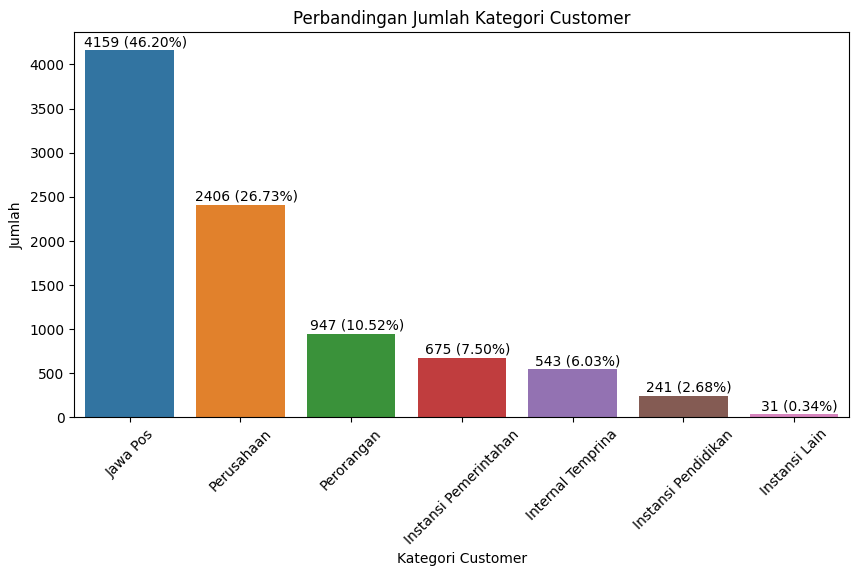

In [89]:
#Barplot Customer
cust = data['CUSTOMER'].value_counts().reset_index()
cust.columns = ['Customer','Jumlah']

plt.figure(figsize=(10,5))
ax = sns.barplot(x='Customer', y='Jumlah', data=cust,hue='Customer')
plt.xticks(rotation=45)
plt.xlabel('Kategori Customer')
plt.ylabel('Jumlah')
plt.title('Perbandingan Jumlah Kategori Customer')
for height in ax.patches:
  y = height.get_height()
  x = height.get_x() + height.get_width()/2
  value = y/np.sum(cust["Jumlah"])*100
  plt.text(x+0.05,y+50,s=f"{int(y)} ({value:.2f}%)",ha = "center")

# plt.savefig('kategori_customer.png', transparent=True)
plt.show()

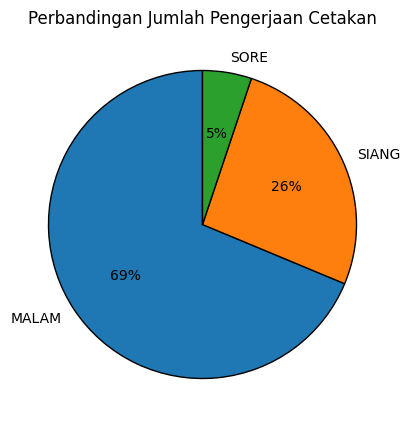

In [90]:
#Piechart Shift
#Jumlah Shift perlu dicek ulang
shiff = data['SHIFT'].value_counts().reset_index()
shiff.columns = ['Shift','Jumlah']

plt.figure(figsize=(10,5))
plt.pie(x=shiff["Jumlah"],labels=shiff["Shift"], autopct='%.0f%%',startangle=90,
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1,
                      'antialiased': True})
plt.title('Perbandingan Jumlah Pengerjaan Cetakan')
plt.show()

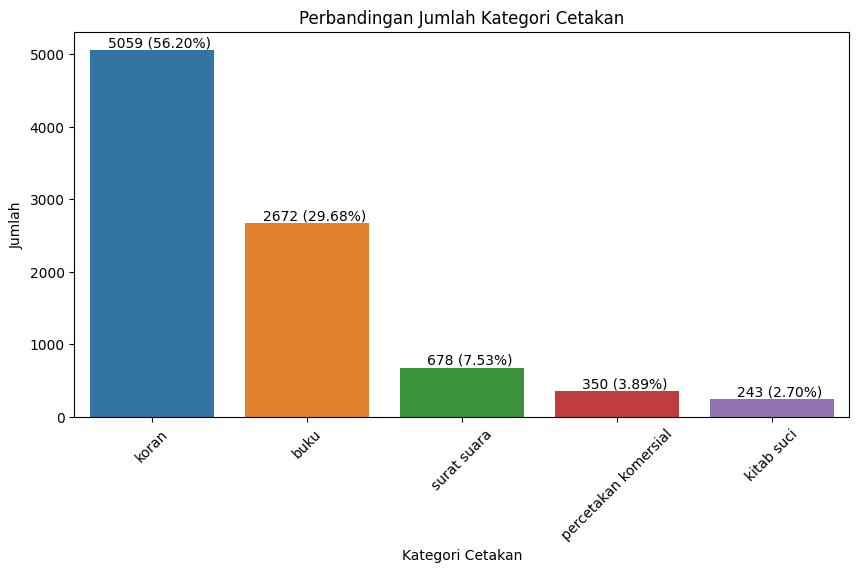

In [91]:
#Barplot / Piechart Cetakan
#KAtegori Cetakan perlu dikelompokkan lagi
cetakan = data['KATEGORI_CETAKAN'].value_counts().reset_index().head(5)
cetakan.columns = ['Kategori','Jumlah']


plt.figure(figsize=(10,5))
ax = sns.barplot(x='Kategori', y='Jumlah', data=cetakan,hue='Kategori')
plt.xticks(rotation=45)
plt.xlabel('Kategori Cetakan')
plt.ylabel('Jumlah')
plt.title('Perbandingan Jumlah Kategori Cetakan')
for height in ax.patches:
  y = height.get_height()
  x = height.get_x() + height.get_width()/2
  value = y/np.sum(cetakan["Jumlah"])*100
  plt.text(x+0.05,y+50,s=f"{int(y)} ({value:.2f}%)",ha = "center")
# plt.savefig('kategori_cetakan.png', transparent=True)
plt.show()

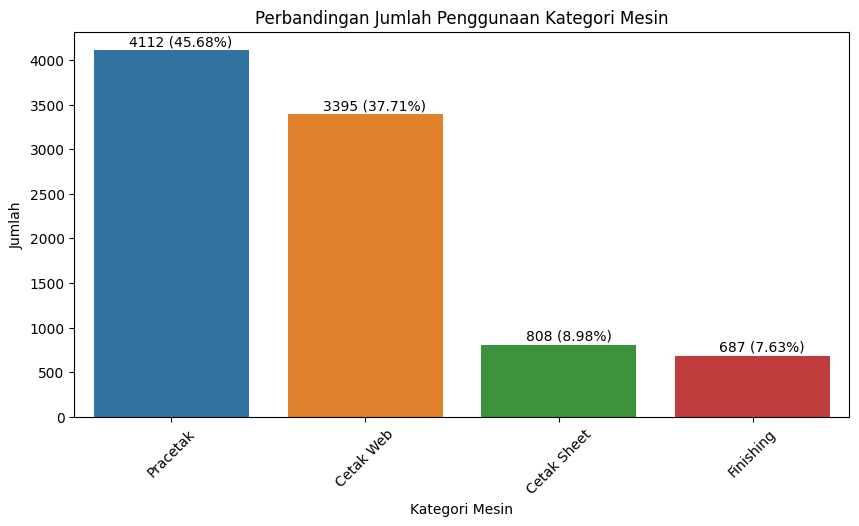

In [92]:
#Barplot / Piechart Cetakan
#KAtegori Cetakan perlu dikelompokkan lagi
mesin = data['KATEGORI_MESIN'].value_counts().reset_index().head(5)
mesin.columns = ['Kategori','Jumlah']


plt.figure(figsize=(10,5))
ax = sns.barplot(x='Kategori', y='Jumlah', data=mesin,hue='Kategori')
plt.xticks(rotation=45)
plt.xlabel('Kategori Mesin')
plt.ylabel('Jumlah')
plt.title('Perbandingan Jumlah Penggunaan Kategori Mesin')
for height in ax.patches:
  y = height.get_height()
  x = height.get_x() + height.get_width()/2
  value = y/np.sum(mesin["Jumlah"])*100
  plt.text(x+0.05,y+50,s=f"{int(y)} ({value:.2f}%)",ha = "center")
# plt.savefig('kategori_mesin.png', transparent=True)
plt.show()

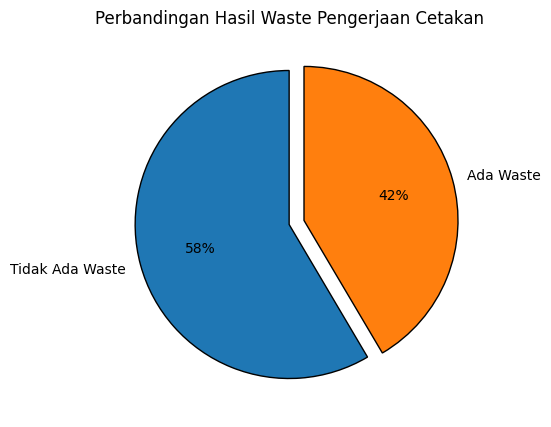

In [93]:
#Piechart ADA WASTE
ada_waste = data['ADA_WASTE'].value_counts().reset_index()
ada_waste.columns = ['Waste','Jumlah']
ada_waste['Waste'] = ada_waste['Waste'].apply(lambda x:"Ada Waste" if x=="Ada" else "Tidak Ada Waste")

plt.figure(figsize=(10,5))
plt.pie(x=ada_waste["Jumlah"],labels=ada_waste["Waste"], autopct='%.0f%%',startangle=90, explode=[0,0.1],
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1,
                      'antialiased': True})
plt.title('Perbandingan Hasil Waste Pengerjaan Cetakan')
plt.savefig('waste_mesin.png', transparent=True)
plt.show()

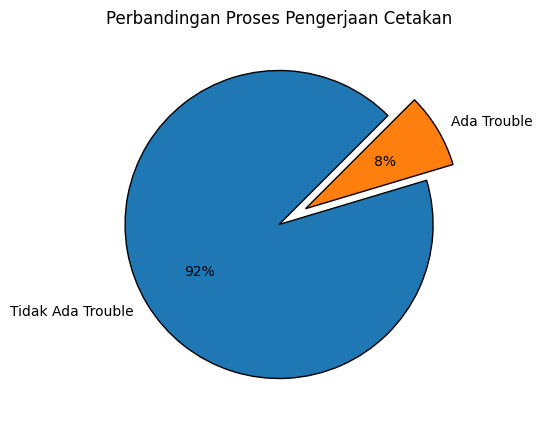

In [94]:
#Piechart ADA Trouble
ada_trouble = data['ADA_TROUBLE'].value_counts().reset_index()
ada_trouble.columns = ['Trouble','Jumlah']
ada_trouble['Trouble'] = ada_trouble['Trouble'].apply(lambda x:"Ada Trouble" if x=='Ada' else "Tidak Ada Trouble")

plt.figure(figsize=(10,5))
plt.pie(x=ada_trouble["Jumlah"],labels=ada_trouble["Trouble"], autopct='%.0f%%',startangle=45, explode=[0,0.2],
        wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1,
                      'antialiased': True})

plt.title('Perbandingan Proses Pengerjaan Cetakan')
# plt.savefig('trouble_mesin.png', transparent=True)
plt.show()

## Variabel Numerik

In [95]:
data.describe(include="number").round(2)

OPLAH_MEDIA  HASIL_CETAK  JUMLAH_BAHAN  JUMLAH_PENGGUNAAN  \
count      9002.00      9002.00       9002.00            9002.00   
mean      30010.77      3639.65        476.79               1.57   
std      140769.69      8193.80       3775.58               2.00   
min           1.00         0.00          0.00               1.00   
25%        2050.00        13.00         10.00               1.00   
50%        3998.50       868.00         23.00               1.00   
75%       12000.00      3063.75        120.00               1.00   
max     2267157.00    186000.00     147657.50              44.00   

       DURASI_SETTING  DURASI_MESIN  LAMA_TROUBLE  JUMLAH_WASTE  \
count         9002.00       9002.00       9002.00       9002.00   
mean             0.18          1.83          0.08          7.42   
std              0.57         12.81          0.80         53.10   
min              0.00          0.00          0.00          0.00   
25%              0.00          0.17          0.00          0.00   
50%              0.00          0.28          0.00          0.00   
75%              0.08          0.75          0.00          1.00   
max             13.48        361.33         35.02       2094.00   

       DURASI_REALISASI  DURASI_RENCANA  PENYIMPANGAN_DURASI  %PENYIMPANGAN  \
count           9002.00         9002.00              9002.00        9002.00   
mean               1.93            0.69                 1.24          56.84   
std               12.78            5.14                12.70          92.68   
min                0.00            0.00               -99.31       -4620.00   
25%                0.22            0.00                 0.20          75.86   
50%                0.33            0.00                 0.28          75.86   
75%                0.90            0.00                 0.57          75.86   
max              361.33          128.40               361.33          99.74   

       CETAK_BAIK  
count     8988.00  
mean        99.81  
std          2.38  
min       -100.00  
25%         99.94  
50%        100.00  
75%        100.00  
max        100.00

In [96]:
#Histogram Variabel
# sns.histplot(x = data["OPLAH_MEDIA"],hue=data["KATEGORI_MESIN"],kde=True)
# plt.title('Distribution of Customer\'s MonthlyCharges by Churn Status')

# # plt.axvline(x=df_train.loc[df_train['Churn']==0,'MonthlyCharges'].mean())
# # plt.text(x=29,y=450,s="Avg. MonthlyCharges \n for Churn")
# # plt.axvline(x=df_train.loc[df_train['Churn']==1,'MonthlyCharges'].mean(),color='orange')
# # plt.text(x=76,y=450,s="Avg. MonthlyCharges \n for Not Churn")

# # hands, labs = ax.get_legend_handles_labels()
# # plt.legend(handles=hands, labels=['Not Churn', 'Churn'])
# plt.show()

## Hubungan variabel prediktor dengan respon

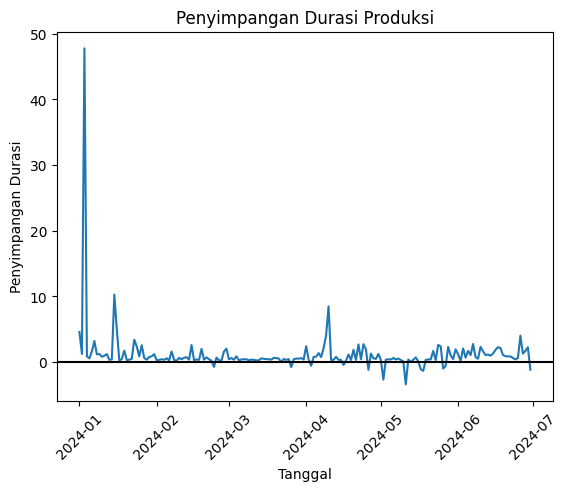

In [97]:
#Grafik Penyimpangan
ax = sns.lineplot(data=data, x="TANGGAL", y="PENYIMPANGAN_DURASI",estimator="mean",errorbar=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.axhline(y=0,color="black")
plt.title("Penyimpangan Durasi Produksi")
plt.xlabel("Tanggal")
plt.ylabel("Penyimpangan Durasi")
plt.show()

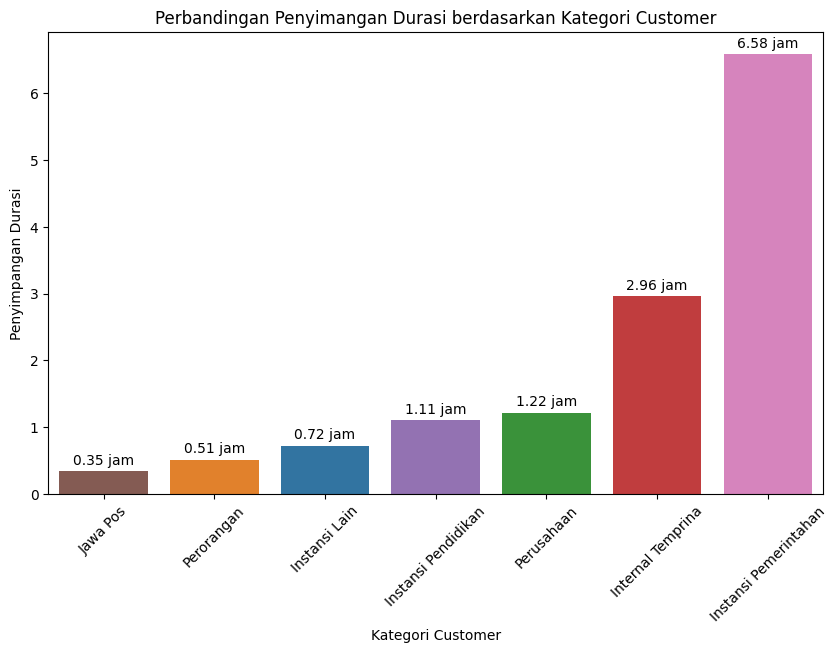

In [98]:
#Barplot Customer

plt.figure(figsize=(10,6))

urut = data.groupby(["CUSTOMER"])['PENYIMPANGAN_DURASI'].mean().reset_index().sort_values('PENYIMPANGAN_DURASI')
ax = sns.barplot(x='CUSTOMER', y='PENYIMPANGAN_DURASI', data=data,hue='CUSTOMER',estimator="mean",errorbar=None,order=urut["CUSTOMER"])
plt.xticks(rotation=45)
plt.xlabel('Kategori Customer')
plt.ylabel('Penyimpangan Durasi')
plt.title('Perbandingan Penyimangan Durasi berdasarkan Kategori Customer')
for height in ax.patches:
  y = height.get_height()
  x = height.get_x() + height.get_width()/2
  value = y/np.sum(cust["Jumlah"])*100
  plt.text(x,y+0.1,s=f"{y.round(2)} jam",ha = "center")

plt.show()

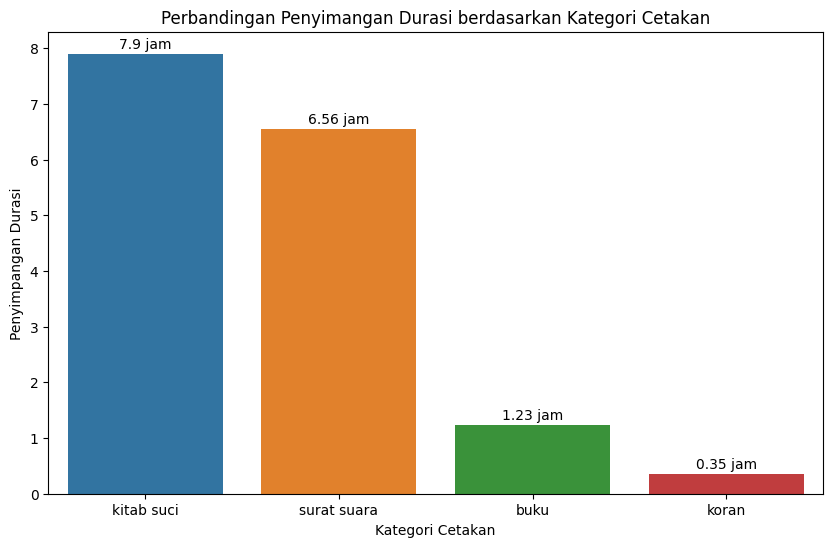

In [99]:
#Barplot Cetakan

plt.figure(figsize=(10,6))

cetakan = data.groupby("KATEGORI_CETAKAN")['PENYIMPANGAN_DURASI'].mean().reset_index().sort_values('PENYIMPANGAN_DURASI',ascending=False)
cetakan = cetakan.loc[cetakan["KATEGORI_CETAKAN"]!="percetakan komersial",:]
urut = data.groupby(["KATEGORI_CETAKAN"])['PENYIMPANGAN_DURASI'].mean().reset_index().sort_values('PENYIMPANGAN_DURASI')
# ax = sns.barplot(x='KATEGORI_CETAKAN', y='PENYIMPANGAN_DURASI', data=data,hue='KATEGORI_CETAKAN',estimator="mean",errorbar=None,order=urut["KATEGORI_CETAKAN"])
ax = sns.barplot(data=cetakan,x="KATEGORI_CETAKAN",y="PENYIMPANGAN_DURASI",hue="KATEGORI_CETAKAN")
# plt.xticks(rotation=45)
plt.xlabel('Kategori Cetakan')
plt.ylabel('Penyimpangan Durasi')
plt.title('Perbandingan Penyimangan Durasi berdasarkan Kategori Cetakan')
for height in ax.patches:
  y = height.get_height()
  x = height.get_x() + height.get_width()/2
  value = y/np.sum(cust["Jumlah"])*100
  plt.text(x,y+0.1,s=f"{y.round(2)} jam",ha = "center")

plt.show()

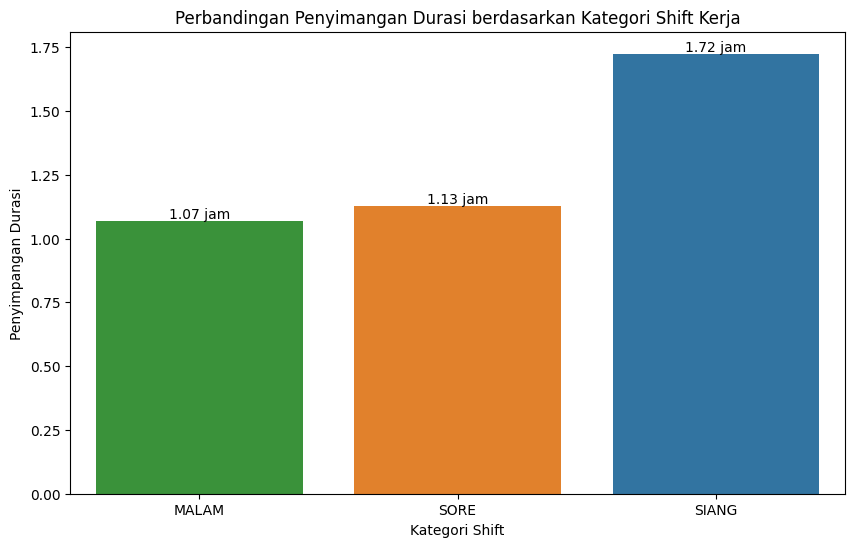

In [100]:
#Barplot Customer

plt.figure(figsize=(10,6))

urut = data.groupby(["SHIFT"])['PENYIMPANGAN_DURASI'].mean().reset_index().sort_values('PENYIMPANGAN_DURASI')
ax = sns.barplot(x='SHIFT', y='PENYIMPANGAN_DURASI', data=data,hue='SHIFT',estimator="mean",errorbar=None,order=urut["SHIFT"])
# plt.xticks(rotation=45)
plt.xlabel('Kategori Shift')
plt.ylabel('Penyimpangan Durasi')
plt.title('Perbandingan Penyimangan Durasi berdasarkan Kategori Shift Kerja')
for height in ax.patches:
  y = height.get_height()
  x = height.get_x() + height.get_width()/2
  value = y/np.sum(cust["Jumlah"])*100
  plt.text(x,y+0.01,s=f"{y.round(2)} jam",ha = "center")

plt.show()

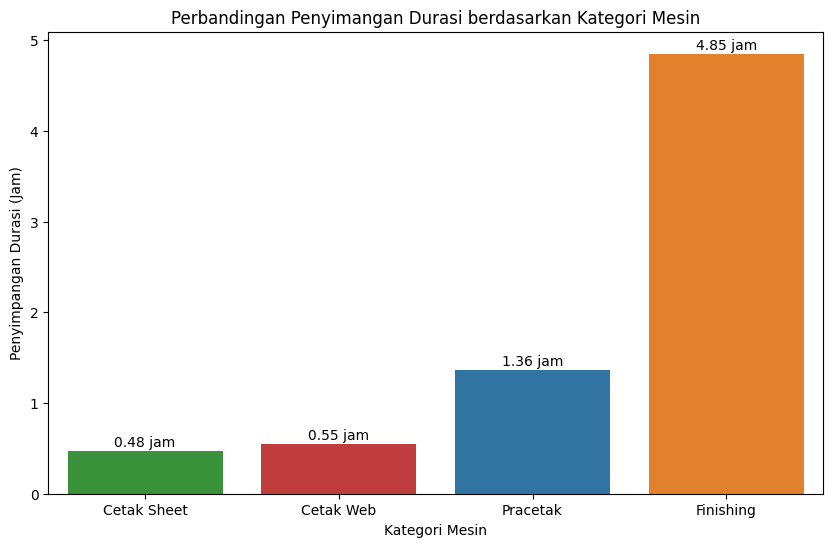

In [101]:
#Barplot Customer

plt.figure(figsize=(10,6))

urut = data.groupby(["KATEGORI_MESIN"])['PENYIMPANGAN_DURASI'].mean().reset_index().sort_values('PENYIMPANGAN_DURASI')
ax = sns.barplot(x='KATEGORI_MESIN', y='PENYIMPANGAN_DURASI', data=data,hue='KATEGORI_MESIN',estimator="mean",errorbar=None,order=urut["KATEGORI_MESIN"])
# plt.xticks(rotation=45)
plt.xlabel('Kategori Mesin')
plt.ylabel('Penyimpangan Durasi (Jam)')
plt.title('Perbandingan Penyimangan Durasi berdasarkan Kategori Mesin')
for height in ax.patches:
  y = height.get_height()
  x = height.get_x() + height.get_width()/2
  value = y/np.sum(cust["Jumlah"])*100
  plt.text(x,y+0.05,s=f"{y.round(2)} jam",ha = "center")
# plt.savefig('penyimpangan_mesin.png', transparent=True)
plt.show()

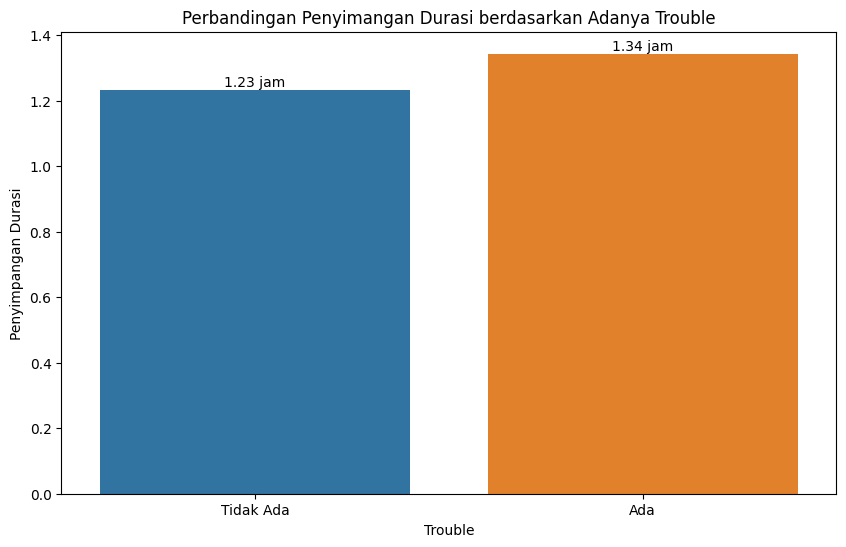

In [102]:
#Barplot Customer

plt.figure(figsize=(10,6))

urut = data.groupby(["ADA_TROUBLE"])['PENYIMPANGAN_DURASI'].mean().reset_index().sort_values('PENYIMPANGAN_DURASI')
ax = sns.barplot(x='ADA_TROUBLE', y='PENYIMPANGAN_DURASI', data=data,hue='ADA_TROUBLE',estimator="mean",errorbar=None,order=urut["ADA_TROUBLE"])
plt.xlabel('Trouble')
plt.ylabel('Penyimpangan Durasi')
plt.title('Perbandingan Penyimangan Durasi berdasarkan Adanya Trouble')
for height in ax.patches:
  y = height.get_height()
  x = height.get_x() + height.get_width()/2
  value = y/np.sum(cust["Jumlah"])*100
  plt.text(x,y+0.01,s=f"{y.round(2)} jam",ha = "center")

plt.show()

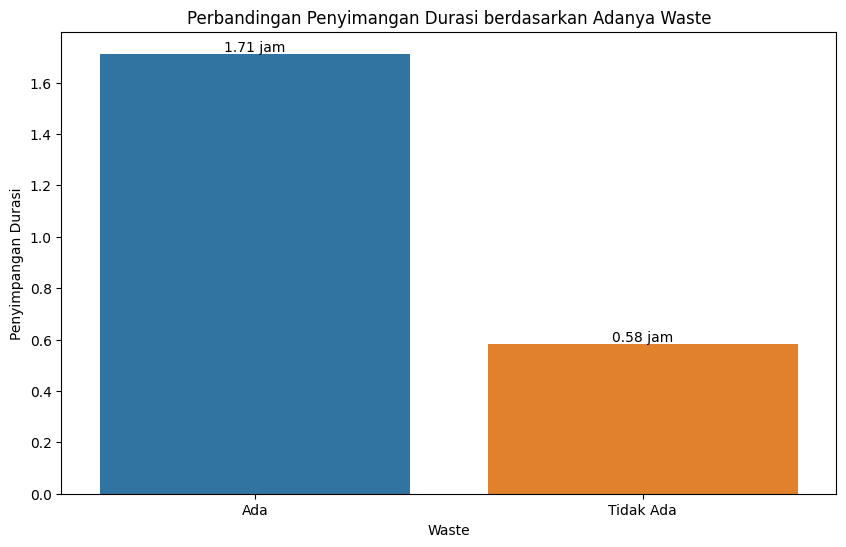

In [103]:
#Barplot Customer

plt.figure(figsize=(10,6))

urut = data.groupby(["ADA_WASTE"])['PENYIMPANGAN_DURASI'].mean().reset_index().sort_values('PENYIMPANGAN_DURASI')
ax = sns.barplot(x='ADA_WASTE', y='PENYIMPANGAN_DURASI', data=data,hue='ADA_WASTE',estimator="mean",errorbar=None)
LABELS = ['Ada', "Tidak Ada"]
plt.xticks(["Tidak Ada",'Ada'], LABELS)
plt.xlabel('Waste')
plt.ylabel('Penyimpangan Durasi')
plt.title('Perbandingan Penyimangan Durasi berdasarkan Adanya Waste')
for height in ax.patches:
  y = height.get_height()
  x = height.get_x() + height.get_width()/2
  value = y/np.sum(cust["Jumlah"])*100
  plt.text(x,y+0.01,s=f"{y.round(2)} jam",ha = "center")

plt.show()

In [104]:
#scatterplot penyimpangan vs numerik

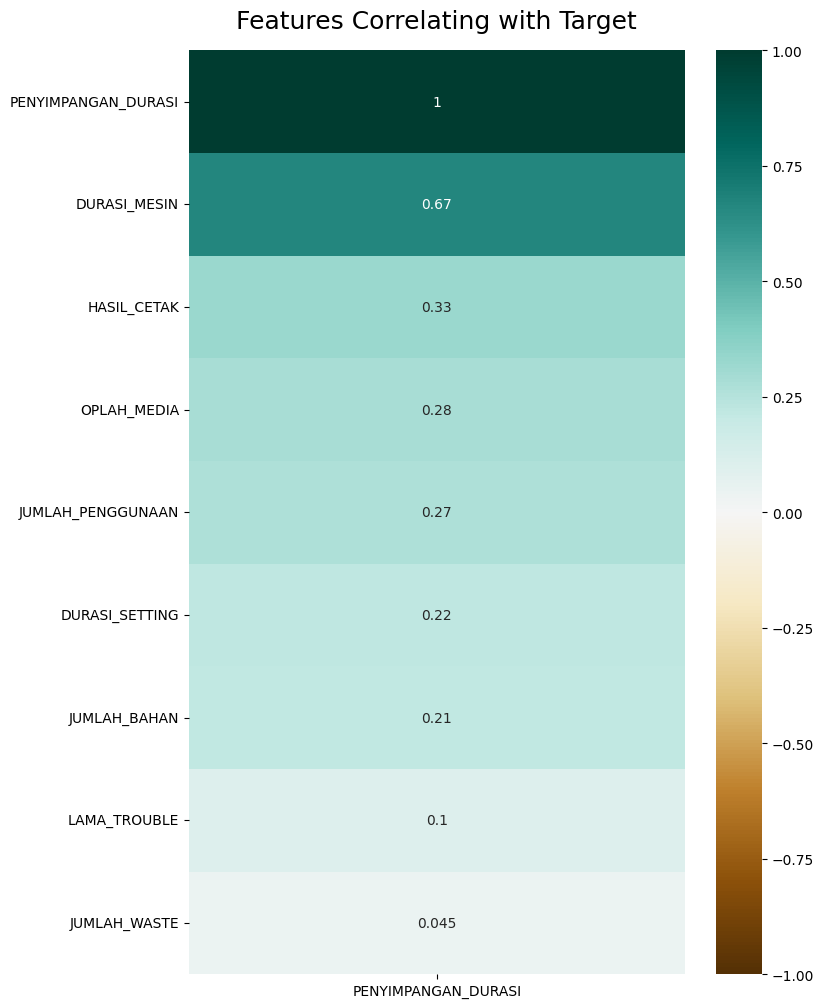

In [105]:
#heatmap penyimpangan vs prediktor
korelasi = data.select_dtypes(include="number")
korelasi = korelasi.drop(columns=["DURASI_REALISASI","%PENYIMPANGAN", "DURASI_RENCANA", "CETAK_BAIK"])
korelasi = korelasi.corr("spearman")[['PENYIMPANGAN_DURASI']].sort_values(by='PENYIMPANGAN_DURASI', ascending=False)

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(korelasi, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Target', fontdict={'fontsize':18}, pad=16);
# plt.savefig('heatmap.png', transparent=True)
plt.show()

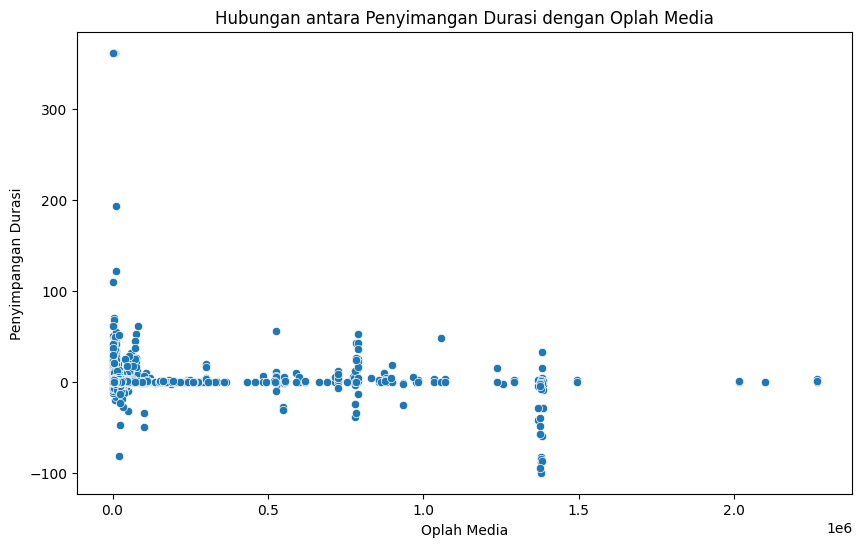

In [106]:
#Barplot Customer

plt.figure(figsize=(10,6))

# urut = data.groupby(["ADA_WASTE"])['PENYIMPANGAN_DURASI'].mean().reset_index().sort_values('PENYIMPANGAN_DURASI')
ax = sns.scatterplot(x='OPLAH_MEDIA', y='PENYIMPANGAN_DURASI', data=data)
plt.xlabel('Oplah Media')
plt.ylabel('Penyimpangan Durasi')
plt.title('Hubungan antara Penyimangan Durasi dengan Oplah Media')

plt.show()

# Hypothesis Testing

## Variabel kategorik vs Target

In [107]:
result = data.groupby('SHIFT')['PENYIMPANGAN_DURASI'].apply(list)
result

SHIFT
MALAM    [0.20848000000000003, 0.6502999999999999, 0.14...
SIANG    [0.0, 0.42999999999999994, 1.42, 0.20848000000...
SORE     [0.2499999999999999, 3.6500000000000004, 0.077...
Name: PENYIMPANGAN_DURASI, dtype: object

In [108]:
F, p = f_oneway(*result)
print (F)
print (p)

2.293049766016408
0.10101707987812424


In [109]:
def create_anova(df,kategorik,value):
  df_anova = df.groupby(kategorik)[value].mean().reset_index()
  kelas = df.groupby(kategorik)[value].apply(list)

  #One Way ANOVA
  stat, pvalue = f_oneway(*kelas)
  H0 = f"there is no difference in the average {value} in each category of {kategorik}"
  Ha = f"there is a difference in the average {value} of at least one pair of categories of {kategorik}"
  if pvalue < 0.05:
    y = f"H0 is rejected, so we have enough evident that {Ha}"
  else:
    y = f"H0 is accapeted, so {H0}"
  anova = [H0, Ha, stat, pvalue, y]

  #Pairwise Tukey
  tukey = pairwise_tukeyhsd(endog=df[value],
                          groups=df[kategorik],
                          alpha=0.05)
  return df_anova, anova, tukey

### Kategori Customer

In [110]:
df_customer, anova_customer, tukey_customer = create_anova(data,"CUSTOMER","PENYIMPANGAN_DURASI")
df_customer.sort_values(by="PENYIMPANGAN_DURASI")

CUSTOMER  PENYIMPANGAN_DURASI
4               Jawa Pos             0.346338
5             Perorangan             0.512049
0          Instansi Lain             0.724194
2    Instansi Pendidikan             1.108506
6             Perusahaan             1.215480
3      Internal Temprina             2.958085
1  Instansi Pemerintahan             6.584756

In [111]:
print("Hypoyhesis")
print(f"H0 : {anova_customer[0]}")
print(f"H1 : {anova_customer[1]}")
print(f"Test Statistics : {anova_customer[2]}")
print(f"P-value : {anova_customer[3].round(4)}")
print("Conclusion")
print(anova_customer[4])

Hypoyhesis
H0 : there is no difference in the average PENYIMPANGAN_DURASI in each category of CUSTOMER
H1 : there is a difference in the average PENYIMPANGAN_DURASI of at least one pair of categories of CUSTOMER
Test Statistics : 25.96791902186956
P-value : 0.0
Conclusion
H0 is rejected, so we have enough evident that there is a difference in the average PENYIMPANGAN_DURASI of at least one pair of categories of CUSTOMER


In [112]:
print(tukey_customer)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------
        Instansi Lain Instansi Pemerintahan   5.8606 0.1476 -0.9627 12.6838  False
        Instansi Lain   Instansi Pendidikan   0.3843    1.0 -6.7036  7.4722  False
        Instansi Lain     Internal Temprina   2.2339 0.9623 -4.6257  9.0935  False
        Instansi Lain              Jawa Pos  -0.3779    1.0 -7.0745  6.3188  False
        Instansi Lain            Perorangan  -0.2121    1.0 -6.9923   6.568  False
        Instansi Lain            Perusahaan   0.4913    1.0 -6.2233  7.2059  False
Instansi Pemerintahan   Instansi Pendidikan  -5.4763    0.0 -8.2637 -2.6888   True
Instansi Pemerintahan     Internal Temprina  -3.6267    0.0 -5.7681 -1.4853   True
Instansi Pemerintahan              Jawa Pos  -6.2384    0.0 -7.7799  -4.697   True
Inst

### Kategori Mesin

In [113]:
df_mesin, anova_mesin, tukey_mesin = create_anova(data,"KATEGORI_MESIN","PENYIMPANGAN_DURASI")
df_mesin.sort_values(by="PENYIMPANGAN_DURASI")

KATEGORI_MESIN  PENYIMPANGAN_DURASI
0    Cetak Sheet             0.476605
1      Cetak Web             0.550373
3       Pracetak             1.362659
2      Finishing             4.852197

In [114]:
print("Hypoyhesis")
print(f"H0 : {anova_mesin[0]}")
print(f"H1 : {anova_mesin[1]}")
print(f"Test Statistics : {anova_mesin[2]}")
print(f"P-value : {anova_mesin[3].round(4)}")
print("Conclusion")
print(anova_mesin[4])

Hypoyhesis
H0 : there is no difference in the average PENYIMPANGAN_DURASI in each category of KATEGORI_MESIN
H1 : there is a difference in the average PENYIMPANGAN_DURASI of at least one pair of categories of KATEGORI_MESIN
Test Statistics : 23.129343127963363
P-value : 0.0
Conclusion
H0 is rejected, so we have enough evident that there is a difference in the average PENYIMPANGAN_DURASI of at least one pair of categories of KATEGORI_MESIN


In [115]:
print(tukey_mesin)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1     group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------------
Cetak Sheet Cetak Web   0.0738 0.9988  -1.199  1.3465  False
Cetak Sheet Finishing   4.3756    0.0  2.6882   6.063   True
Cetak Sheet  Pracetak   0.8861 0.2641 -0.3652  2.1373  False
  Cetak Web Finishing   4.3018    0.0  2.9415  5.6621   True
  Cetak Web  Pracetak   0.8123 0.0289  0.0583  1.5663   True
  Finishing  Pracetak  -3.4895    0.0 -4.8297 -2.1494   True
------------------------------------------------------------


### Kategori Shift

In [116]:
df_shift, anova_shift, tukey_shift = create_anova(data,"SHIFT","PENYIMPANGAN_DURASI")
df_shift.sort_values(by="PENYIMPANGAN_DURASI")

SHIFT  PENYIMPANGAN_DURASI
0  MALAM             1.068762
2   SORE             1.125931
1  SIANG             1.724462

In [117]:
print("Hypoyhesis")
print(f"H0 : {anova_shift[0]}")
print(f"H1 : {anova_shift[1]}")
print(f"Test Statistics : {anova_shift[2]}")
print(f"P-value : {anova_shift[3].round(4)}")
print("Conclusion")
print(anova_shift[4])

Hypoyhesis
H0 : there is no difference in the average PENYIMPANGAN_DURASI in each category of SHIFT
H1 : there is a difference in the average PENYIMPANGAN_DURASI of at least one pair of categories of SHIFT
Test Statistics : 2.293049766016408
P-value : 0.101
Conclusion
H0 is accapeted, so there is no difference in the average PENYIMPANGAN_DURASI in each category of SHIFT


In [118]:
print(tukey_shift)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 MALAM  SIANG   0.6557 0.0836 -0.0653 1.3767  False
 MALAM   SORE   0.0572 0.9952 -1.3771 1.4914  False
 SIANG   SORE  -0.5985 0.6232  -2.112 0.9149  False
---------------------------------------------------


### Kategori Cetakan

In [119]:
df_cetakan, anova_cetakan, tukey_cetakan = create_anova(data,"KATEGORI_CETAKAN","PENYIMPANGAN_DURASI")
df_cetakan.sort_values(by="PENYIMPANGAN_DURASI")

KATEGORI_CETAKAN  PENYIMPANGAN_DURASI
3  percetakan komersial            -0.602575
2                 koran             0.345910
0                  buku             1.230229
4           surat suara             6.555222
1            kitab suci             7.899815

In [120]:
print("Hypoyhesis")
print(f"H0 : {anova_cetakan[0]}")
print(f"H1 : {anova_cetakan[1]}")
print(f"Test Statistics : {anova_cetakan[2]}")
print(f"P-value : {anova_cetakan[3].round(4)}")
print("Conclusion")
print(anova_cetakan[4])

Hypoyhesis
H0 : there is no difference in the average PENYIMPANGAN_DURASI in each category of KATEGORI_CETAKAN
H1 : there is a difference in the average PENYIMPANGAN_DURASI of at least one pair of categories of KATEGORI_CETAKAN
Test Statistics : 55.82594239679163
P-value : 0.0
Conclusion
H0 is rejected, so we have enough evident that there is a difference in the average PENYIMPANGAN_DURASI of at least one pair of categories of KATEGORI_CETAKAN


In [121]:
print(tukey_cetakan)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
       group1               group2        meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------------
                buku           kitab suci   6.6696    0.0   4.3755  8.9636   True
                buku                koran  -0.8843 0.0267  -1.7031 -0.0655   True
                buku percetakan komersial  -1.8328 0.0762  -3.7791  0.1134  False
                buku          surat suara    5.325    0.0   3.8527  6.7973   True
          kitab suci                koran  -7.5539    0.0  -9.8024 -5.3054   True
          kitab suci percetakan komersial  -8.5024    0.0 -11.3613 -5.6435   True
          kitab suci          surat suara  -1.3446 0.6062  -3.9044  1.2153  False
               koran percetakan komersial  -0.9485 0.6486  -2.8408  0.9438  False
               koran          surat suara   6.2093    0.0   4.8091  7.6095   True
percetakan komer

### Ada Waste

In [122]:
df_waste, anova_waste, tukey_waste = create_anova(data,"ADA_WASTE","PENYIMPANGAN_DURASI")
df_waste.sort_values(by="PENYIMPANGAN_DURASI")

ADA_WASTE  PENYIMPANGAN_DURASI
0        Ada             0.582025
1  Tidak Ada             1.712093

In [123]:
print("Hypoyhesis")
print(f"H0 : {anova_waste[0]}")
print(f"H1 : {anova_waste[1]}")
print(f"Test Statistics : {anova_waste[2]}")
print(f"P-value : {anova_waste[3].round(4)}")
print("Conclusion")
print(anova_waste[4])

Hypoyhesis
H0 : there is no difference in the average PENYIMPANGAN_DURASI in each category of ADA_WASTE
H1 : there is a difference in the average PENYIMPANGAN_DURASI of at least one pair of categories of ADA_WASTE
Test Statistics : 17.3330941768923
P-value : 0.0
Conclusion
H0 is rejected, so we have enough evident that there is a difference in the average PENYIMPANGAN_DURASI of at least one pair of categories of ADA_WASTE


In [124]:
print(tukey_waste)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1   group2  meandiff p-adj lower upper  reject
---------------------------------------------------
   Ada Tidak Ada   1.1301   0.0 0.598 1.6621   True
---------------------------------------------------


### Ada Trouble

In [125]:
df_trouble, anova_trouble, tukey_trouble = create_anova(data,"ADA_TROUBLE","PENYIMPANGAN_DURASI")
df_trouble.sort_values(by="PENYIMPANGAN_DURASI")

ADA_TROUBLE  PENYIMPANGAN_DURASI
1   Tidak Ada             1.234488
0         Ada             1.343905

In [126]:
print("Hypoyhesis")
print(f"H0 : {anova_trouble[0]}")
print(f"H1 : {anova_trouble[1]}")
print(f"Test Statistics : {anova_trouble[2]}")
print(f"P-value : {anova_trouble[3].round(4)}")
print("Conclusion")
print(anova_trouble[4])

Hypoyhesis
H0 : there is no difference in the average PENYIMPANGAN_DURASI in each category of ADA_TROUBLE
H1 : there is a difference in the average PENYIMPANGAN_DURASI of at least one pair of categories of ADA_TROUBLE
Test Statistics : 0.04840750604259725
P-value : 0.8259
Conclusion
H0 is accapeted, so there is no difference in the average PENYIMPANGAN_DURASI in each category of ADA_TROUBLE


In [127]:
print(tukey_trouble)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2  meandiff p-adj   lower  upper  reject
------------------------------------------------------
   Ada Tidak Ada  -0.1094 0.8259 -1.0843 0.8654  False
------------------------------------------------------


## Variabel Numerik vs Target

In [128]:
def spearman_corr(df,numerik,target):
  #Spearman Corr
  spearman = spearmanr(df[numerik], df[target])
  stat = spearman.statistic
  pvalue = spearman.pvalue

  H0 = f"there is no significant correlation between {numerik} and {target}"
  Ha = f"there is significant correlation between {numerik} and {target}"
  if pvalue < 0.05:
    y = f"H0 is rejected, so we have enough evident that {Ha}"
  else:
    y = f"H0 is accapeted, so {H0}"
  spearman = [H0, Ha, stat, pvalue, y]
  return spearman

In [129]:
def pearson_corr(df,numerik,target):
  #Pearson Corr
  pearson = pearsonr(df[numerik], df[target])
  stat = pearson.statistic
  pvalue = pearson.pvalue

  H0 = f"there is no significant correlation between {numerik} and {target}"
  Ha = f"there is significant correlation between {numerik} and {target}"
  if pvalue < 0.05:
    y = f"H0 is rejected, so we have enough evident that {Ha}"
  else:
    y = f"H0 is accapeted, so {H0}"
  pearson = [H0, Ha, stat, pvalue, y]
  return pearson

In [130]:
data.select_dtypes(include="number").columns

Index(['OPLAH_MEDIA', 'HASIL_CETAK', 'JUMLAH_BAHAN', 'JUMLAH_PENGGUNAAN',
       'DURASI_SETTING', 'DURASI_MESIN', 'LAMA_TROUBLE', 'JUMLAH_WASTE',
       'DURASI_REALISASI', 'DURASI_RENCANA', 'PENYIMPANGAN_DURASI',
       '%PENYIMPANGAN', 'CETAK_BAIK'],
      dtype='object')

In [131]:
for i in data.select_dtypes(include="number").columns:
  korelasi = spearman_corr(data,i,"PENYIMPANGAN_DURASI")
  print(f"r-spearman {i} = {np.round(korelasi[2],2)}\n")
  print(f"P-value Variabel {i} = {np.round(korelasi[3],2)}\n")

r-spearman OPLAH_MEDIA = 0.28

P-value Variabel OPLAH_MEDIA = 0.0

r-spearman HASIL_CETAK = 0.33

P-value Variabel HASIL_CETAK = 0.0

r-spearman JUMLAH_BAHAN = 0.21

P-value Variabel JUMLAH_BAHAN = 0.0

r-spearman JUMLAH_PENGGUNAAN = 0.27

P-value Variabel JUMLAH_PENGGUNAAN = 0.0

r-spearman DURASI_SETTING = 0.22

P-value Variabel DURASI_SETTING = 0.0

r-spearman DURASI_MESIN = 0.67

P-value Variabel DURASI_MESIN = 0.0

r-spearman LAMA_TROUBLE = 0.1

P-value Variabel LAMA_TROUBLE = 0.0

r-spearman JUMLAH_WASTE = 0.04

P-value Variabel JUMLAH_WASTE = 0.0

r-spearman DURASI_REALISASI = 0.72

P-value Variabel DURASI_REALISASI = 0.0

r-spearman DURASI_RENCANA = -0.21

P-value Variabel DURASI_RENCANA = 0.0

r-spearman PENYIMPANGAN_DURASI = 1.0

P-value Variabel PENYIMPANGAN_DURASI = 0.0

r-spearman %PENYIMPANGAN = 0.34

P-value Variabel %PENYIMPANGAN = 0.0

r-spearman CETAK_BAIK = nan

P-value Variabel CETAK_BAIK = nan



In [132]:
data["KAT_OPLAH_MEDIA"] = pd.cut(data['OPLAH_MEDIA'],[0,500,1000,5000,10000,100000])
data["KAT_OPLAH_MEDIA"].value_counts()

KAT_OPLAH_MEDIA
(1000, 5000]       5201
(10000, 100000]    1963
(5000, 10000]      1034
(500, 1000]         425
(0, 500]             39
Name: count, dtype: int64

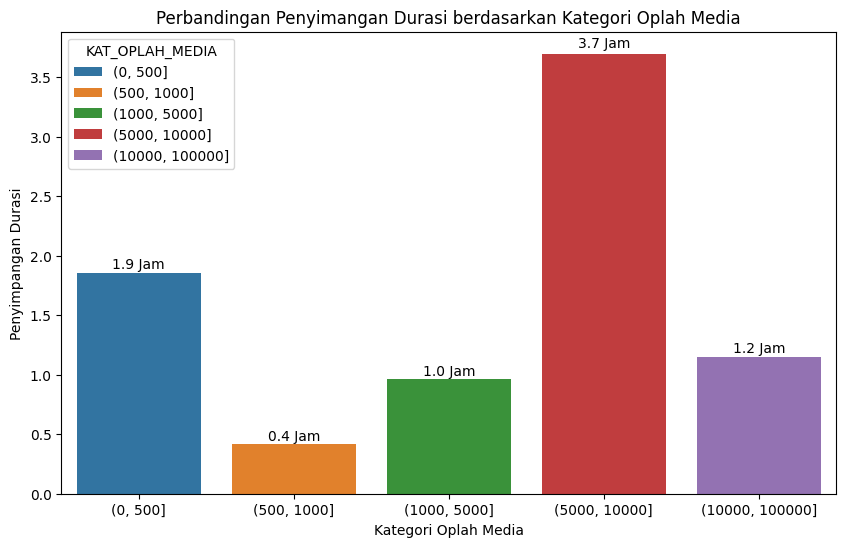

In [133]:
#Barplot Customer

plt.figure(figsize=(10,6))

# urut = data.groupby(["KAT_OPLAH_MEDIA"])['PENYIMPANGAN_DURASI'].mean().round(2).reset_index().sort_values('PENYIMPANGAN_DURASI')
ax = sns.barplot(x='KAT_OPLAH_MEDIA', y='PENYIMPANGAN_DURASI', data=data,hue='KAT_OPLAH_MEDIA',estimator="mean",errorbar=None)
# plt.xticks(rotation=45)
plt.xlabel('Kategori Oplah Media')
plt.ylabel('Penyimpangan Durasi')
plt.title('Perbandingan Penyimangan Durasi berdasarkan Kategori Oplah Media')
i = 0
for p in ax.patches:
  if i == 5:
    break
  else:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
    value = '{:.1f}'.format(p.get_height())
    ax.text(_x, _y+0.02, f"{value} Jam", ha="center")
    i = i+1

plt.show()

In [134]:
data["KAT_HASIL_CETAK"] = pd.cut(data['HASIL_CETAK'],[0,500,1000,5000,10000,100000])
data["KAT_HASIL_CETAK"].value_counts()

KAT_HASIL_CETAK
(0, 500]           4175
(1000, 5000]       2878
(10000, 100000]    1012
(5000, 10000]       573
(500, 1000]         344
Name: count, dtype: int64

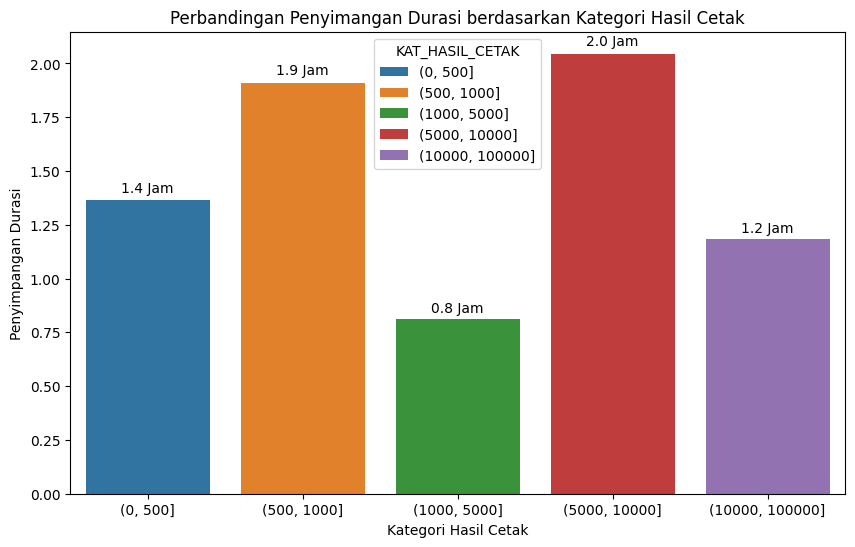

In [135]:
#Barplot Customer

plt.figure(figsize=(10,6))

# urut = data.groupby(["KAT_OPLAH_MEDIA"])['PENYIMPANGAN_DURASI'].mean().round(2).reset_index().sort_values('PENYIMPANGAN_DURASI')
ax = sns.barplot(x='KAT_HASIL_CETAK', y='PENYIMPANGAN_DURASI', data=data,hue='KAT_HASIL_CETAK',estimator="mean",errorbar=None)
# plt.xticks(rotation=45)
plt.xlabel('Kategori Hasil Cetak')
plt.ylabel('Penyimpangan Durasi')
plt.title('Perbandingan Penyimangan Durasi berdasarkan Kategori Hasil Cetak')
i = 0
for p in ax.patches:
  if i == 5:
    break
  else:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
    value = '{:.1f}'.format(p.get_height())
    ax.text(_x, _y+0.02, f"{value} Jam", ha="center")
    i = i+1

plt.show()

In [136]:
data["KAT_DURASI_MESIN"] = pd.cut(data['DURASI_MESIN'],[0,1,12,24,48,72])
data["KAT_DURASI_MESIN"].value_counts()

KAT_DURASI_MESIN
(0, 1]      7181
(1, 12]     1621
(12, 24]      95
(24, 48]      54
(48, 72]      24
Name: count, dtype: int64

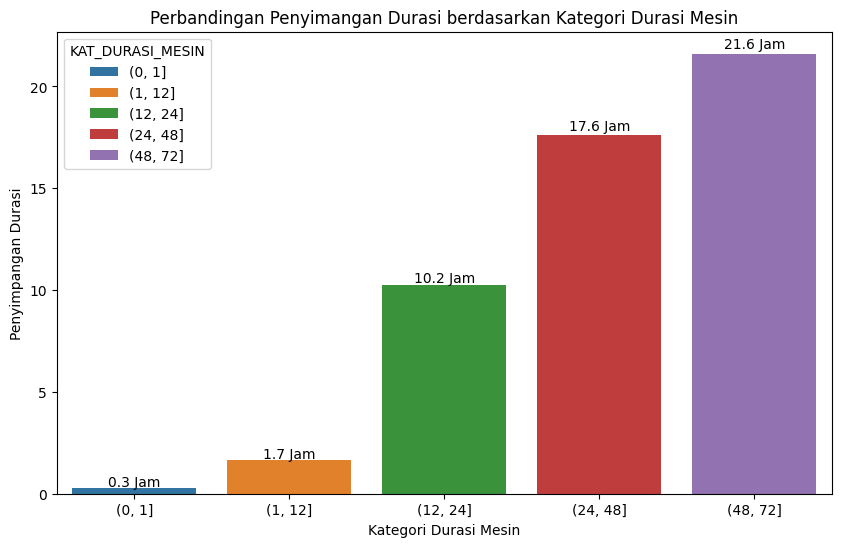

In [137]:
#Barplot Customer

plt.figure(figsize=(10,6))
data['PENYIMPANGAN_DURASI'] = data['PENYIMPANGAN_DURASI'].round(2)
# urut = data.groupby(["KAT_OPLAH_MEDIA"])['PENYIMPANGAN_DURASI'].mean().round(2).reset_index().sort_values('PENYIMPANGAN_DURASI')
ax = sns.barplot(x='KAT_DURASI_MESIN', y='PENYIMPANGAN_DURASI', data=data,hue='KAT_DURASI_MESIN',estimator="mean",errorbar=None)
# plt.xticks(rotation=45)
plt.xlabel('Kategori Durasi Mesin')
plt.ylabel('Penyimpangan Durasi')
plt.title('Perbandingan Penyimangan Durasi berdasarkan Kategori Durasi Mesin')
i = 0
for p in ax.patches:
  if i == 5:
    break
  else:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
    value = '{:.1f}'.format(p.get_height())
    ax.text(_x, _y+0.05, f"{value} Jam", ha="center")
    i = i+1

plt.show()

# Statistical Process Control

## Penyimpangan Durasi

### Shift Siang

In [138]:
 simpangan = data.groupby(["TANGGAL","SPK"])[["PENYIMPANGAN_DURASI","DURASI_REALISASI","DURASI_RENCANA"]].sum().reset_index()
 simpangan = simpangan.loc[simpangan["DURASI_RENCANA"]>0]
 simpangan["%PENYIMPANGAN"] = simpangan["PENYIMPANGAN_DURASI"]*100/simpangan["DURASI_RENCANA"]
 simpangan["%PENYIMPANGAN"] = simpangan["%PENYIMPANGAN"].round(2)
 simpangan.loc[simpangan["%PENYIMPANGAN"]<0,"%PENYIMPANGAN"] = 0
 simpangan = simpangan.loc[simpangan['%PENYIMPANGAN']<=100]
 simpangan

TANGGAL               SPK  PENYIMPANGAN_DURASI  DURASI_REALISASI  \
1    2024-01-01  0009/SPK/01-24/1                 0.55              1.15   
2    2024-01-01  0010/SPK/01-24/1                 0.03              0.68   
3    2024-01-01  0011/SPK/01-24/1                 0.00              0.40   
5    2024-01-01  0013/SPK/01-24/1                 0.00              0.40   
6    2024-01-01  0014/SPK/01-24/1                 0.37              1.37   
...         ...               ...                  ...               ...   
6629 2024-06-29  0614/SPK/06-24/1                -0.40              3.60   
6638 2024-06-30  0552/SPK/06-24/1               -15.66              7.74   
6639 2024-06-30  0602/SPK/06-24/1               -10.37              6.23   
6640 2024-06-30  0604/SPK/06-24/1               -22.47              4.63   
6641 2024-06-30  0606/SPK/06-24/1                 3.02             28.92   

      DURASI_RENCANA  %PENYIMPANGAN  
1               0.60          91.67  
2               0.65           4.62  
3               0.40           0.00  
5               0.40           0.00  
6               1.00          37.00  
...              ...            ...  
6629            4.00           0.00  
6638           23.40           0.00  
6639           16.60           0.00  
6640           27.10           0.00  
6641           25.90          11.66  

[1177 rows x 6 columns]

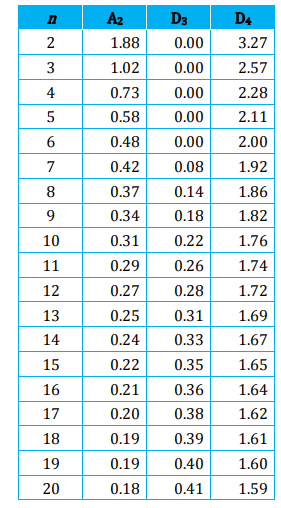

In [139]:
def sampling (df,n,replace=False):
  df = df.groupby(["TANGGAL","SPK"])[["PENYIMPANGAN_DURASI"]].sum().reset_index()
  # df["%PENYIMPANGAN"] = df["PENYIMPANGAN_DURASI"]/df["DURASI_RENCANA"]
  df["TANGGAL"] = df["TANGGAL"].dt.to_period('W')
  df = df.groupby("TANGGAL").apply(lambda x: x.sample(n,random_state=48,replace=replace)).reset_index(drop=True)
  week = []
  for i in range(1,df["TANGGAL"].nunique()+1):
    for j in range(1,n+1):
      if i<10:
        week.append(f"Week 0{i}")
      else:
        week.append(f"Week {i}")
  week = pd.DataFrame(week,columns=["WEEK"])
  df = pd.concat([df,week],axis=1)
  return df

In [140]:
def sampling_2 (df,n,replace=False):
  df = df.groupby(["TANGGAL","SPK"])[["%PENYIMPANGAN"]].sum().reset_index()
  # df["%PENYIMPANGAN"] = df["PENYIMPANGAN_DURASI"]/df["DURASI_RENCANA"]
  df["TANGGAL"] = df["TANGGAL"].dt.to_period('W')
  df = df.groupby("TANGGAL").apply(lambda x: x.sample(n,random_state=10,replace=replace)).reset_index(drop=True)
  week = []
  for i in range(1,df["TANGGAL"].nunique()+1):
    for j in range(1,n+1):
      if i<10:
        week.append(f"Week 0{i}")
      else:
        week.append(f"Week {i}")
  week = pd.DataFrame(week,columns=["WEEK"])
  df = pd.concat([df,week],axis=1)
  return df

In [141]:
def x_chart (df):
  #CL
  Xbar = df.groupby('WEEK')["PENYIMPANGAN_DURASI"].mean()
  Xbar = Xbar.mean()

  R = df.groupby('WEEK')["PENYIMPANGAN_DURASI"].max() - df.groupby('WEEK')["PENYIMPANGAN_DURASI"].min()
  Rbar = R.mean()

  #UCL & LCL
  UCL_X = Xbar + 0.58*Rbar
  LCL_X = Xbar - 0.58*Rbar

  plt.figure(figsize=(15,8))
  ax1 = sns.lineplot(x=df["WEEK"], y=df["PENYIMPANGAN_DURASI"],estimator="mean",errorbar=None,marker='o')
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
  ax1.set_title("Diagram Kendali Xbar")
  ax1.axhline(y=Xbar, color = "red",linestyle = "dashed", label="CL")
  ax1.axhline(y=UCL_X, color = "green",linestyle = "dashed", label="UCL")
  ax1.axhline(y=LCL_X, color = "purple",linestyle = "dashed", label="LCL")
  ax1.axhline(y=0, color = "black",linestyle = "solid")
  plt.legend()
  return ax1, UCL_X, LCL_X, Rbar, Xbar

In [142]:
def x_chart_2 (df):
  #CL
  Xbar = df.groupby('WEEK')["%PENYIMPANGAN"].mean()
  Xbar = Xbar.mean()

  R = df.groupby('WEEK')["%PENYIMPANGAN"].max() - df.groupby('WEEK')["%PENYIMPANGAN"].min()
  Rbar = R.mean()

  #UCL & LCL
  UCL_X = Xbar + 0.58*Rbar
  LCL_X = Xbar - 0.58*Rbar

  plt.figure(figsize=(15,8))
  ax1 = sns.lineplot(x=df["WEEK"], y=df["%PENYIMPANGAN"],estimator="mean",errorbar=None,marker='o')
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
  ax1.set_title("Diagram Kendali Xbar")
  ax1.axhline(y=Xbar, color = "red",linestyle = "dashed", label="CL")
  ax1.axhline(y=UCL_X, color = "green",linestyle = "dashed", label="UCL")
  ax1.axhline(y=LCL_X, color = "purple",linestyle = "dashed", label="LCL")
  ax1.axhline(y=0, color = "black",linestyle = "solid")
  plt.legend()
  return ax1, UCL_X, LCL_X, Rbar, Xbar

In [143]:
def r_chart (df):
  #CL
  R = df.groupby('WEEK')["PENYIMPANGAN_DURASI"].max() - df.groupby('WEEK')["PENYIMPANGAN_DURASI"].min()
  Rbar = R.mean()
  R = R.reset_index()

  #UCL & LCL
  UCL_R = Rbar*2.11
  LCL_R = Rbar*0

  plt.figure(figsize=(15,8))

  ax2 = sns.lineplot(x=R["WEEK"], y=R["PENYIMPANGAN_DURASI"],estimator="mean",errorbar=None,marker='o')
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
  ax2.set_title("Diagram Kendali R")
  ax2.axhline(y=Rbar, color = "red",linestyle = "dashed", label="CL")
  ax2.axhline(y=UCL_R, color = "green",linestyle = "dashed", label="UCL")
  ax2.axhline(y=LCL_R, color = "purple",linestyle = "dashed", label="LCL")
  ax2.axhline(y=0, color = "black",linestyle = "solid")
  plt.legend()
  return ax2

In [144]:
def r_chart_2 (df):
  #CL
  R = df.groupby('WEEK')["%PENYIMPANGAN"].max() - df.groupby('WEEK')["%PENYIMPANGAN"].min()
  Rbar = R.mean()
  R = R.reset_index()

  #UCL & LCL
  UCL_R = Rbar*2.11
  LCL_R = Rbar*0

  plt.figure(figsize=(15,8))

  ax2 = sns.lineplot(x=R["WEEK"], y=R["%PENYIMPANGAN"],estimator="mean",errorbar=None,marker='o')
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
  ax2.set_title("Diagram Kendali R")
  ax2.axhline(y=Rbar, color = "red",linestyle = "dashed", label="CL")
  ax2.axhline(y=UCL_R, color = "green",linestyle = "dashed", label="UCL")
  ax2.axhline(y=LCL_R, color = "purple",linestyle = "dashed", label="LCL")
  ax2.axhline(y=0, color = "black",linestyle = "solid")
  plt.legend()
  return ax2, UCL_R, LCL_R, Rbar

In [145]:
spc = sampling_2(simpangan,5,True)
spc

TANGGAL               SPK  %PENYIMPANGAN     WEEK
0    2024-01-01/2024-01-07  0015/SPK/01-24/1          61.82  Week 01
1    2024-01-01/2024-01-07  0014/SPK/01-24/1          37.00  Week 01
2    2024-01-01/2024-01-07  0004/SPK/01-24/1           1.48  Week 01
3    2024-01-01/2024-01-07  0009/SPK/01-24/1          91.67  Week 01
4    2024-01-01/2024-01-07  0068/SPK/01-24/1           0.00  Week 01
..                     ...               ...            ...      ...
125  2024-06-24/2024-06-30  0601/SPK/06-24/1           0.00  Week 26
126  2024-06-24/2024-06-30  0612/SPK/06-24/1           0.00  Week 26
127  2024-06-24/2024-06-30  0599/SPK/06-24/1          74.29  Week 26
128  2024-06-24/2024-06-30  0369/SPK/06-24/1           0.00  Week 26
129  2024-06-24/2024-06-30  0552/SPK/06-24/1           0.00  Week 26

[130 rows x 4 columns]

In [146]:
spc.head(20)

TANGGAL               SPK  %PENYIMPANGAN     WEEK
0   2024-01-01/2024-01-07  0015/SPK/01-24/1          61.82  Week 01
1   2024-01-01/2024-01-07  0014/SPK/01-24/1          37.00  Week 01
2   2024-01-01/2024-01-07  0004/SPK/01-24/1           1.48  Week 01
3   2024-01-01/2024-01-07  0009/SPK/01-24/1          91.67  Week 01
4   2024-01-01/2024-01-07  0068/SPK/01-24/1           0.00  Week 01
5   2024-01-08/2024-01-14  0480/SPK/10-23/3          76.47  Week 02
6   2024-01-08/2024-01-14  0006/SPK/01-24/4          33.49  Week 02
7   2024-01-08/2024-01-14  0003/SPK/01-24/1          87.67  Week 02
8   2024-01-08/2024-01-14  0480/SPK/10-23/4           0.00  Week 02
9   2024-01-08/2024-01-14  0347/SPK/12-23/1          18.40  Week 02
10  2024-01-15/2024-01-21  0164/SPK/01-24/1          34.75  Week 03
11  2024-01-15/2024-01-21  0006/SPK/01-24/1          60.00  Week 03
12  2024-01-15/2024-01-21  0181/SPK/01-24/1          14.00  Week 03
13  2024-01-15/2024-01-21  0180/SPK/01-24/1          52.51  Week 03
14  2024-01-15/2024-01-21  0347/SPK/12-23/4          60.00  Week 03
15  2024-01-22/2024-01-28  0335/SPK/01-24/1           5.33  Week 04
16  2024-01-22/2024-01-28  0269/SPK/01-24/1          22.67  Week 04
17  2024-01-22/2024-01-28  0335/SPK/01-24/7           5.33  Week 04
18  2024-01-22/2024-01-28  0269/SPK/01-24/1           3.54  Week 04
19  2024-01-22/2024-01-28  0285/SPK/01-24/1           0.00  Week 04

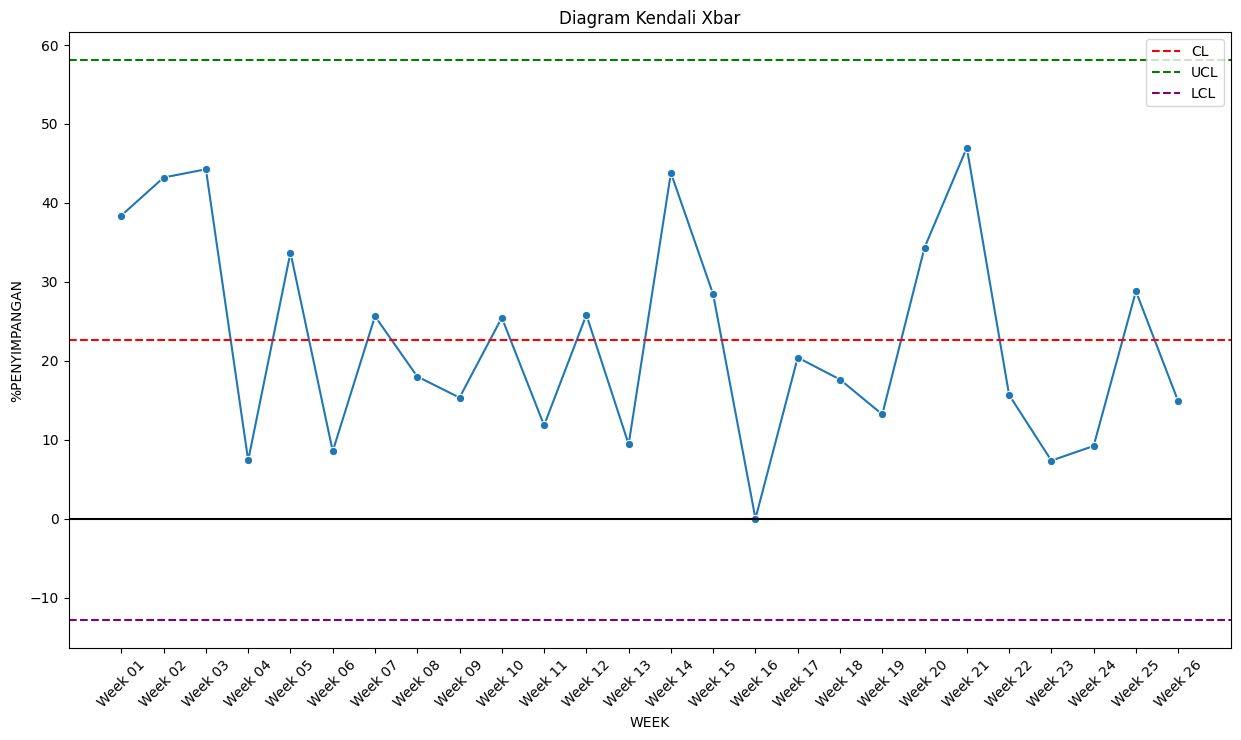

In [147]:
chart_1, ucl_awal, lcl_awal, rbar_awal, xbar_awal = x_chart_2(spc)
plt.show()

Proses Kendali :
- Ada 3 poin pengamatan yang keluar batas (1, 14, 20)

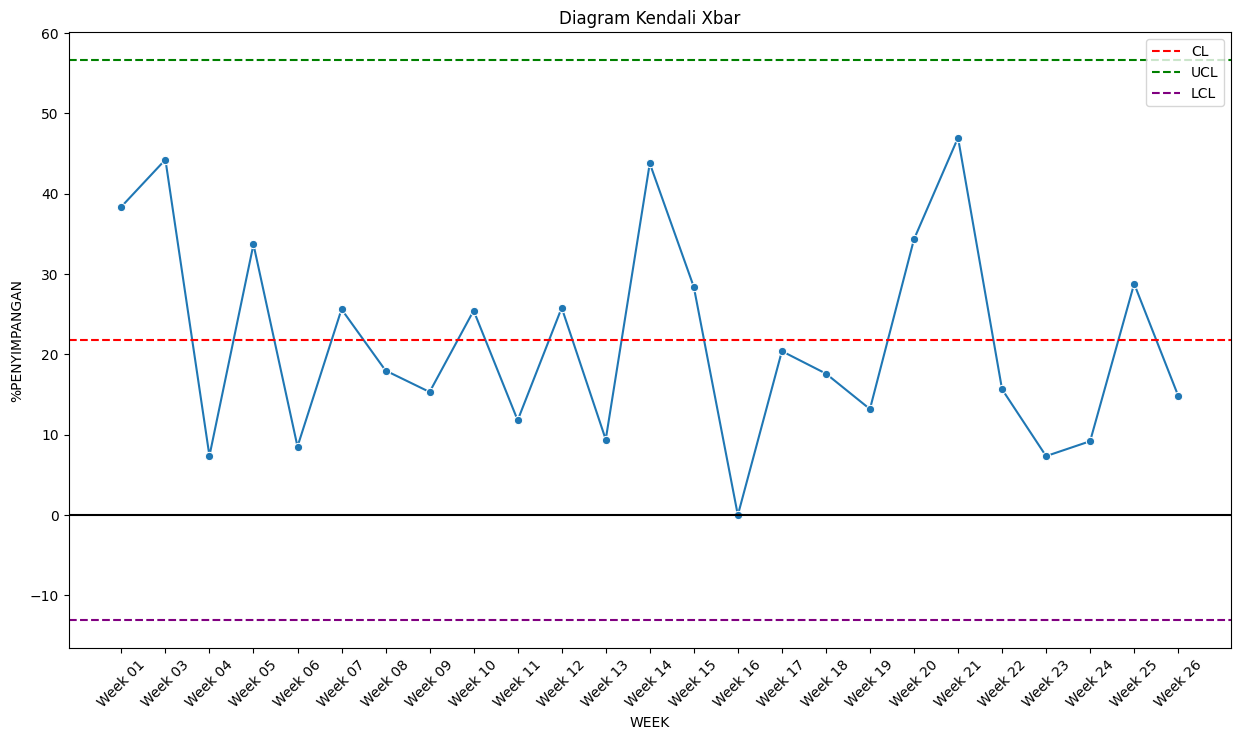

In [148]:
spc_e = spc.copy()
spc_e.drop(spc_e.loc[spc_e["WEEK"].isin(["Week 02"])].index, inplace=True)
chart_2, ucl_2, lcl_2, rbar_2, xbar_2 = x_chart_2(spc_e)
plt.show()

Sudah Terkendali

In [149]:
rbar_awal

61.15346153846154

In [150]:
usl = 30
lsl = -10
cp = (usl - lsl)/((rbar_awal/2.326)*6)
cp

0.2535697289500773

In [151]:
cpu = (usl-xbar_awal)/((rbar_awal/2.326)*3)
cpu

0.09387541473007179

In [152]:
cpl = (xbar_awal-lsl)/((rbar_awal/2.326)*3)
cpl

0.4132640431700828

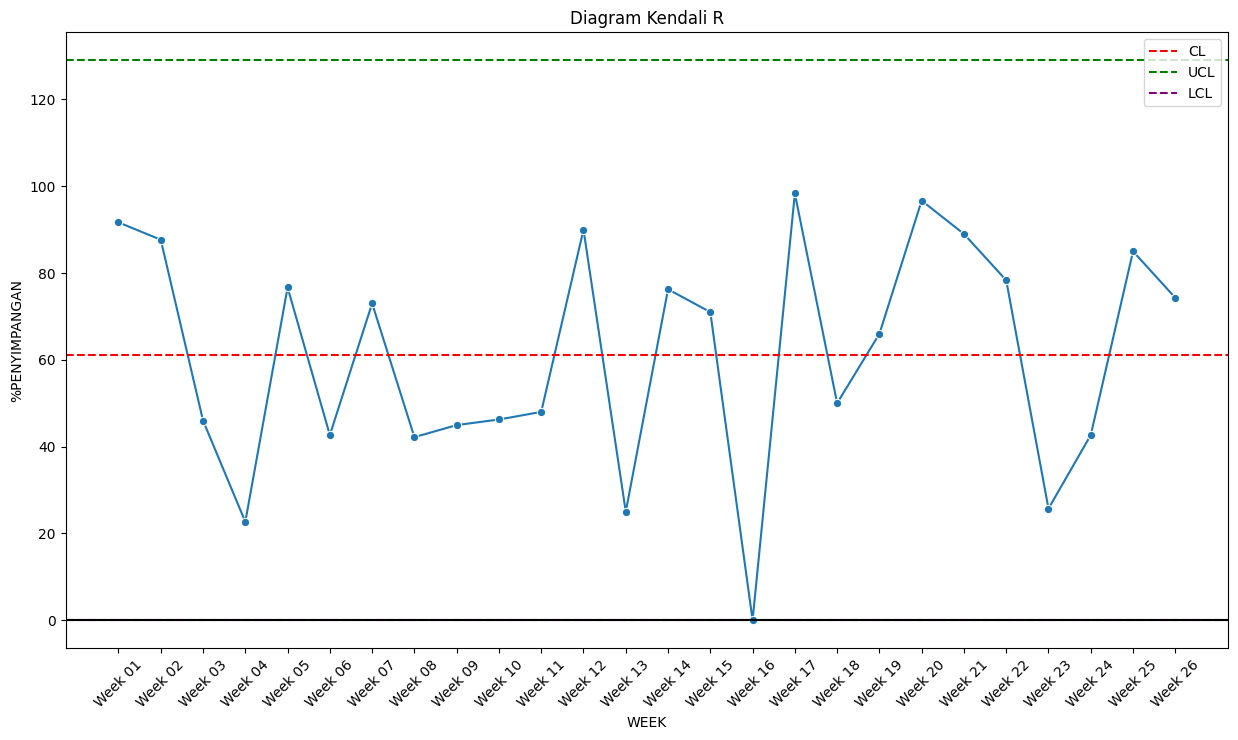

In [153]:
chart_R, uclr_awal, lclr_awal, rbarr_awal = r_chart_2(spc)
plt.show()

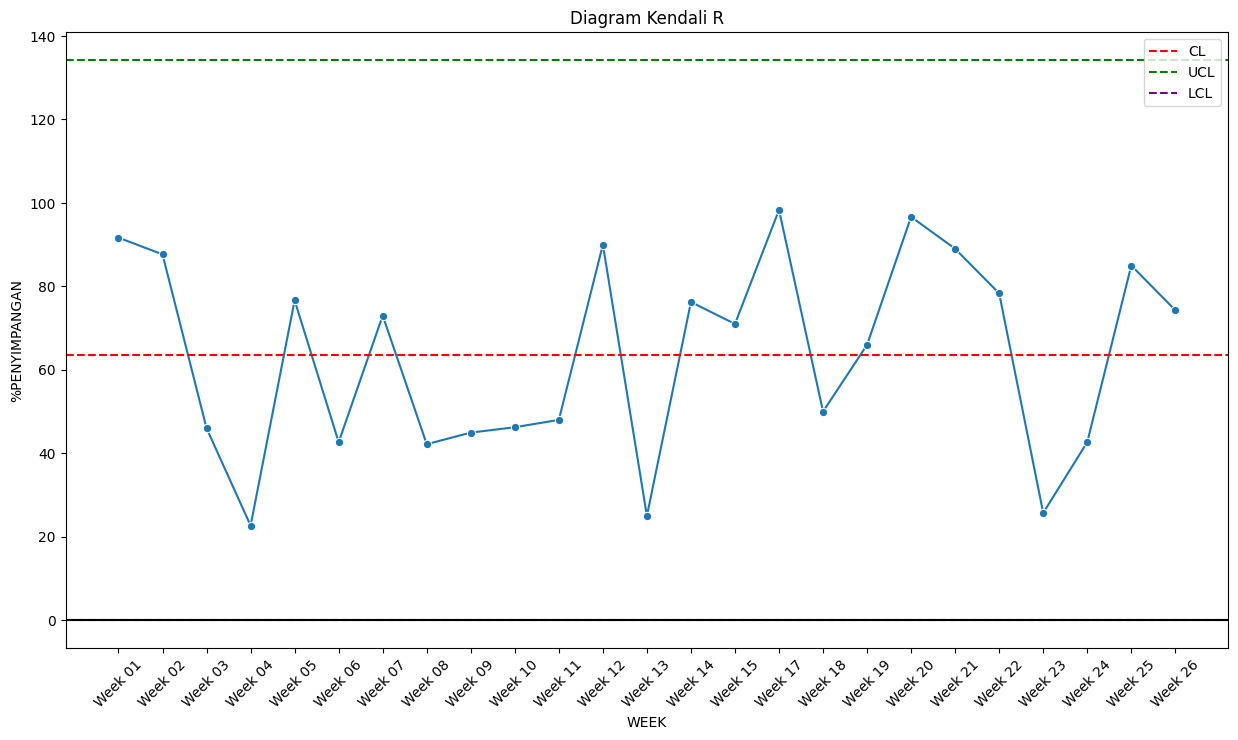

In [154]:
spc_r = spc.copy()
spc_r.drop(spc_e.loc[spc_e["WEEK"].isin(["Week 16"])].index, inplace=True)
chartr_2, uclr_2, lclr_2, rbarr_2 = r_chart_2(spc_r)
plt.show()

### Shift Sore

In [155]:
shift_sore = data.loc[data["SHIFT"]=="SORE",["TANGGAL","SPK","PENYIMPANGAN_DURASI"]]
shift_sore = sampling(shift_sore,5,True)
shift_sore

TANGGAL               SPK  PENYIMPANGAN_DURASI     WEEK
0    2024-01-01/2024-01-07  0649/SPK/12-23/3                 3.98  Week 01
1    2024-01-01/2024-01-07  1017/SPK/11-23/2                 1.32  Week 01
2    2024-01-01/2024-01-07  0649/SPK/12-23/4                 0.67  Week 01
3    2024-01-01/2024-01-07  1017/SPK/11-23/3                 1.32  Week 01
4    2024-01-01/2024-01-07  1017/SPK/11-23/2                 1.32  Week 01
..                     ...               ...                  ...      ...
120  2024-06-24/2024-06-30  0175/SPK/06-24/1                 0.80  Week 25
121  2024-06-24/2024-06-30  0447/SPK/06-24/1                 1.67  Week 25
122  2024-06-24/2024-06-30  0450/SPK/06-24/1                 0.70  Week 25
123  2024-06-24/2024-06-30  0429/SPK/06-24/1                 0.22  Week 25
124  2024-06-24/2024-06-30  0429/SPK/06-24/1                 2.73  Week 25

[125 rows x 4 columns]

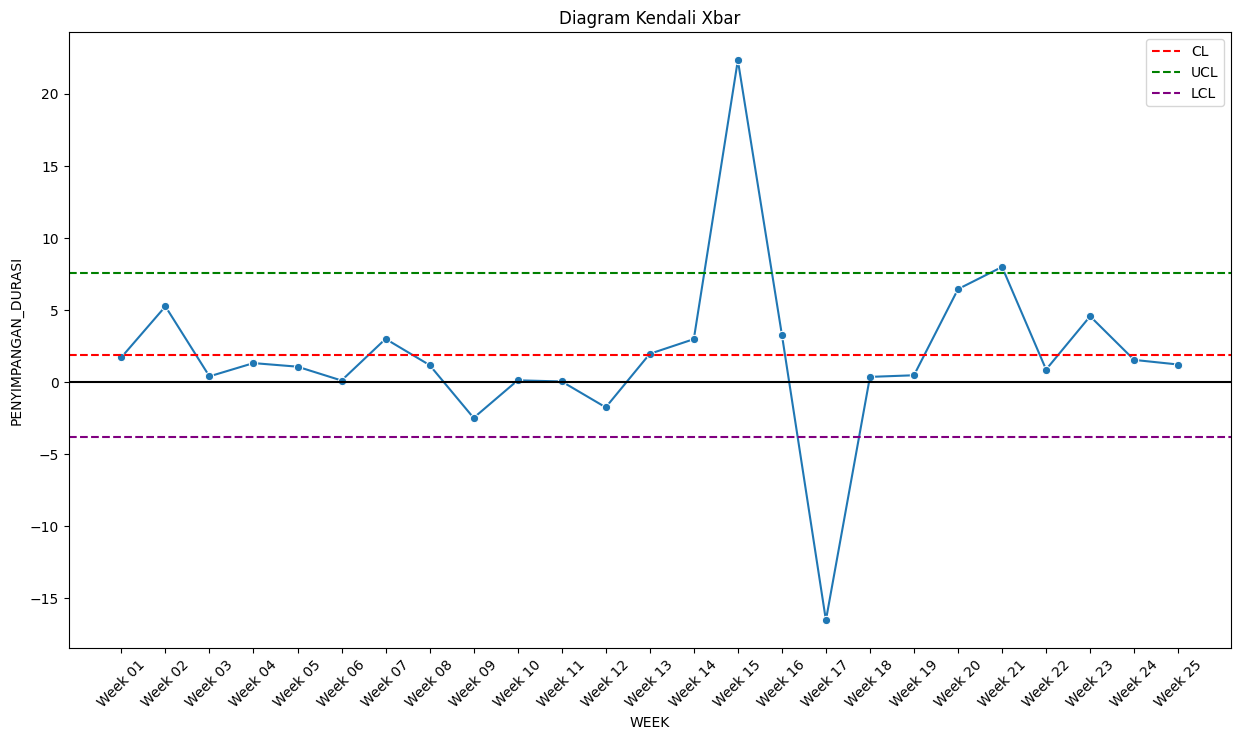

In [156]:
chartx_sore, ucl_awal, lcl_awal, rbar_awal, xbar_awal = x_chart(shift_sore)
plt.show()

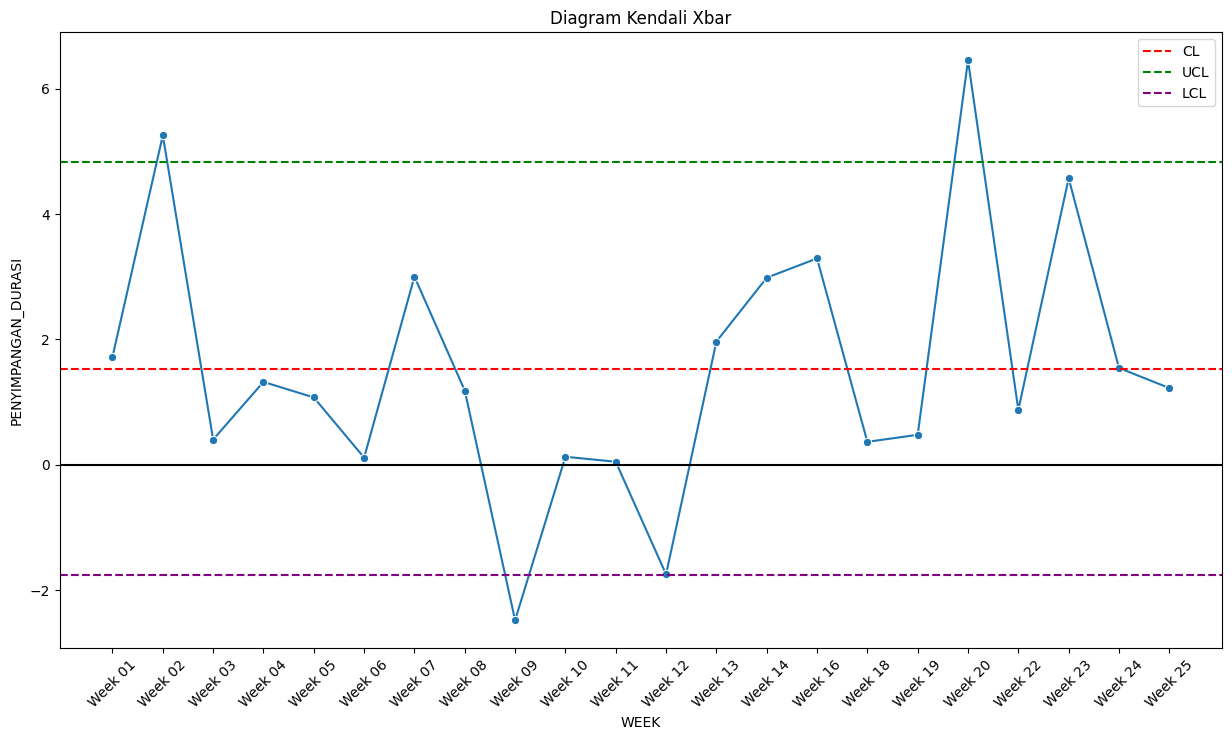

In [157]:
sore_e = shift_sore.copy()
sore_e.drop(sore_e.loc[sore_e["WEEK"].isin(["Week 15", "Week 17", "Week 21"])].index, inplace=True)
# siang_e.loc[siang_e["WEEK"].isin(["Week 01", "Week 14", "Week 20"]),'PENYIMPANGAN_DURASI'] = shift_siang['PENYIMPANGAN_DURASI'].mean()
chartx_sore, ucl, lcl, rbar,xbar = x_chart(sore_e)
plt.show()

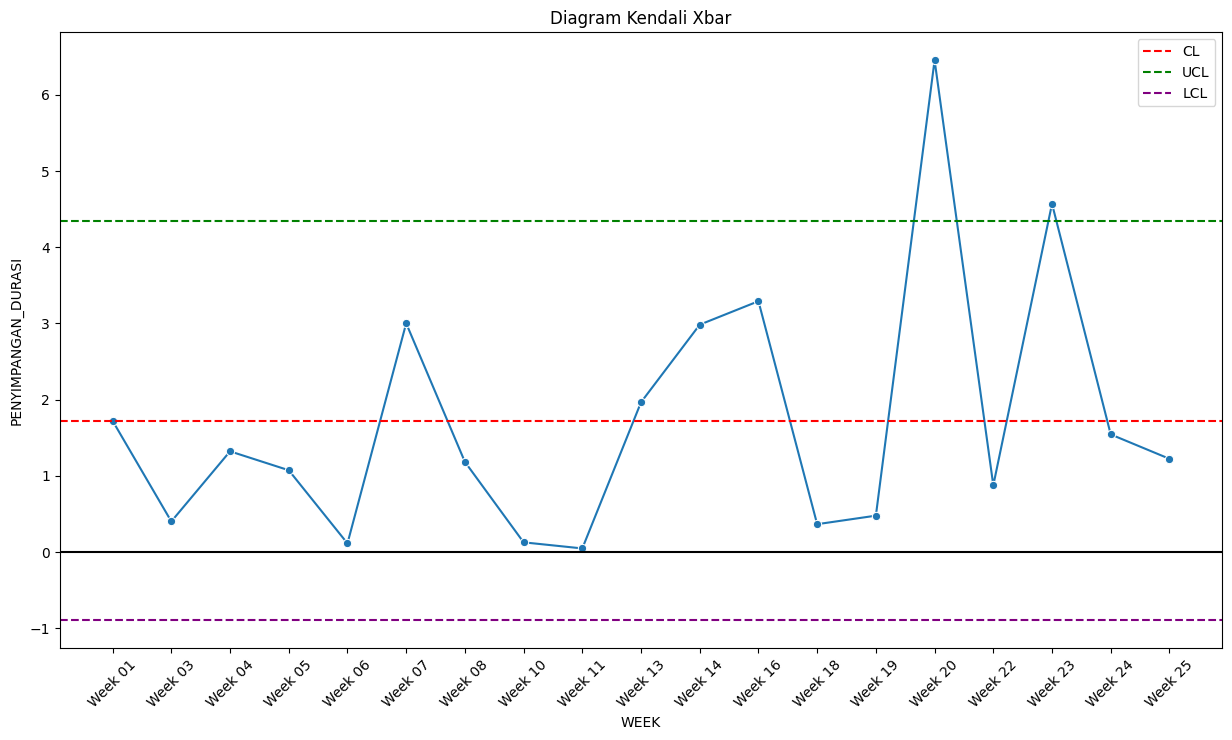

In [158]:
sore_e.drop(sore_e.loc[sore_e["WEEK"].isin(["Week 02", "Week 09", "Week 12", "week 20"])].index, inplace=True)
# siang_e.loc[siang_e["WEEK"].isin(["Week 01", "Week 14", "Week 20"]),'PENYIMPANGAN_DURASI'] = shift_siang['PENYIMPANGAN_DURASI'].mean()
chartx_sore, ucl, lcl, rbar, xbar = x_chart(sore_e)
plt.show()

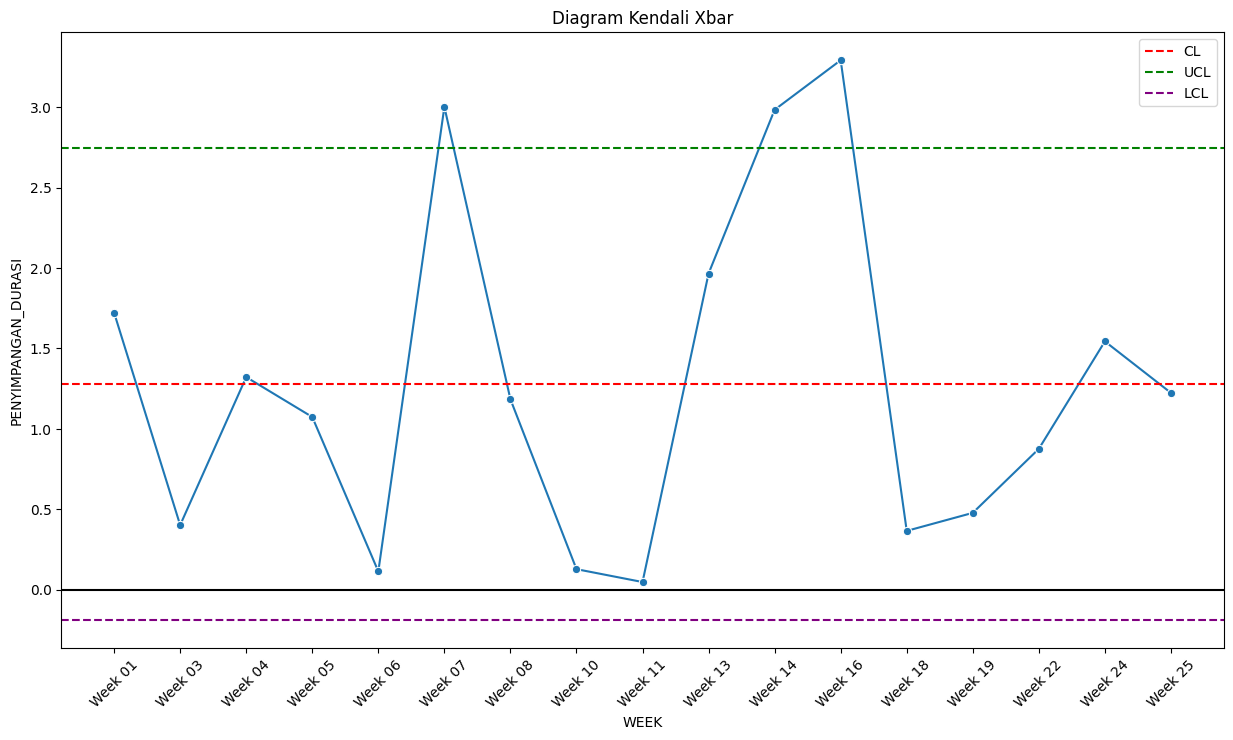

In [159]:
sore_e.drop(sore_e.loc[sore_e["WEEK"].isin(["Week 20", "Week 23"])].index, inplace=True)
# siang_e.loc[siang_e["WEEK"].isin(["Week 01", "Week 14", "Week 20"]),'PENYIMPANGAN_DURASI'] = shift_siang['PENYIMPANGAN_DURASI'].mean()
chartx_sore, ucl, lcl, rbar, xbar = x_chart(sore_e)
plt.show()

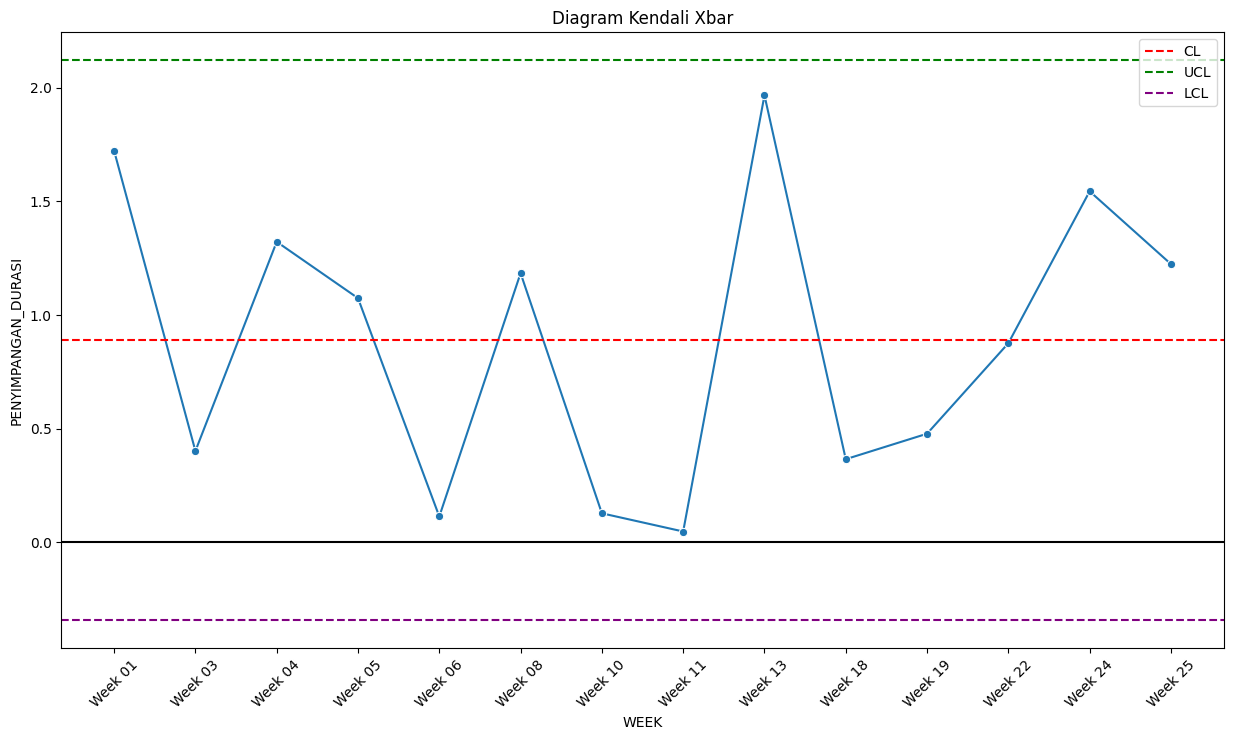

In [160]:
sore_e.drop(sore_e.loc[sore_e["WEEK"].isin(["Week 07", "Week 14" ,"Week 16"])].index, inplace=True)
# siang_e.loc[siang_e["WEEK"].isin(["Week 01", "Week 14", "Week 20"]),'PENYIMPANGAN_DURASI'] = shift_siang['PENYIMPANGAN_DURASI'].mean()
chartx_sore, ucl_sore, lcl_sore, rbar_sore, xbar_sore = x_chart(sore_e)
plt.show()

In [161]:
# cp_sore = (ucl_sore - lcl_sore)/((rbar_sore/2.326)*6)
# cp_sore

### Shift Malam

In [162]:
shift_malam = data.loc[data["SHIFT"]=="MALAM",["TANGGAL","SPK","PENYIMPANGAN_DURASI"]]
shift_malam = sampling(shift_malam,5)
shift_malam

TANGGAL               SPK  PENYIMPANGAN_DURASI     WEEK
0    2024-01-01/2024-01-07  1296/SPK/11-23/2                20.83  Week 01
1    2024-01-01/2024-01-07  0083/SPK/01-24/1                 0.85  Week 01
2    2024-01-01/2024-01-07  0046/SPK/01-24/1                 0.32  Week 01
3    2024-01-01/2024-01-07  0053/SPK/01-24/1                 2.88  Week 01
4    2024-01-01/2024-01-07  0091/SPK/01-24/1                 0.47  Week 01
..                     ...               ...                  ...      ...
125  2024-06-24/2024-06-30  0183/SPK/06-24/1                 2.05  Week 26
126  2024-06-24/2024-06-30  0611/SPK/06-24/1                -0.30  Week 26
127  2024-06-24/2024-06-30  0509/SPK/06-24/1                 0.05  Week 26
128  2024-06-24/2024-06-30  0565/SPK/06-24/1                 0.15  Week 26
129  2024-06-24/2024-06-30  0559/SPK/06-24/1                 0.20  Week 26

[130 rows x 4 columns]

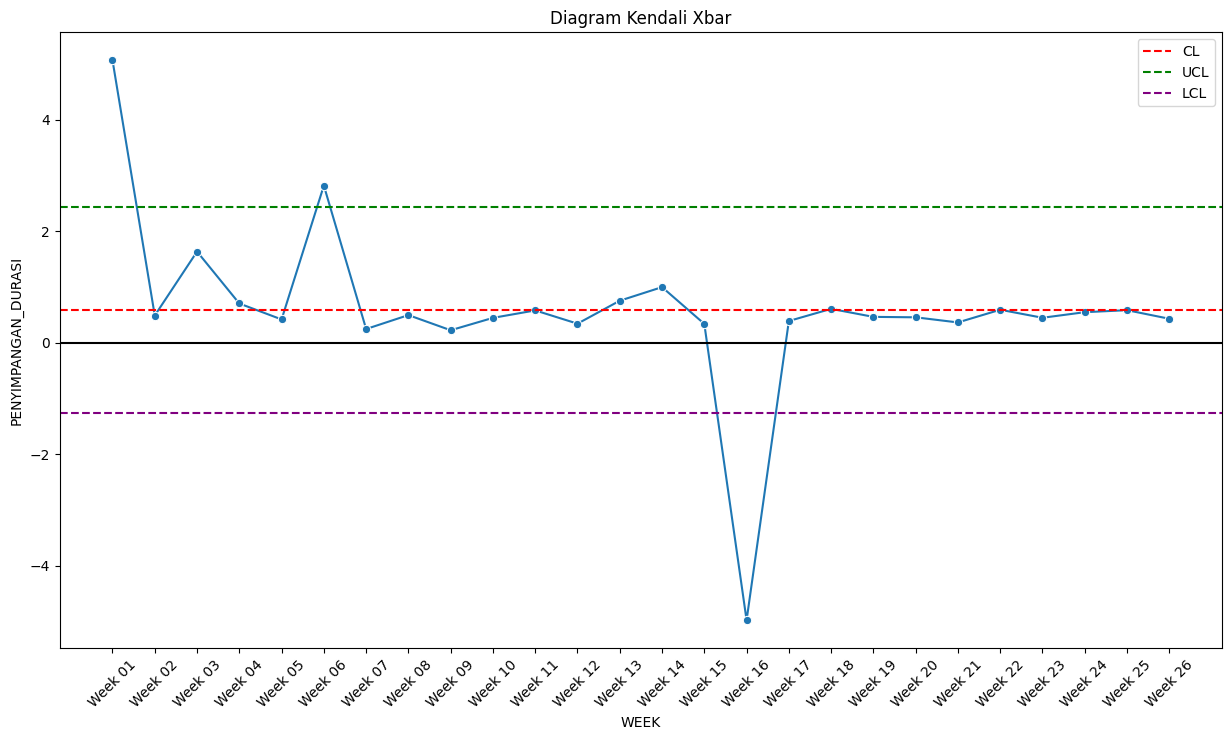

In [163]:
chartx_malam, uclm_awal, lclm_awal, rbarm_awal, xbar_awal = x_chart(shift_malam)
plt.show()

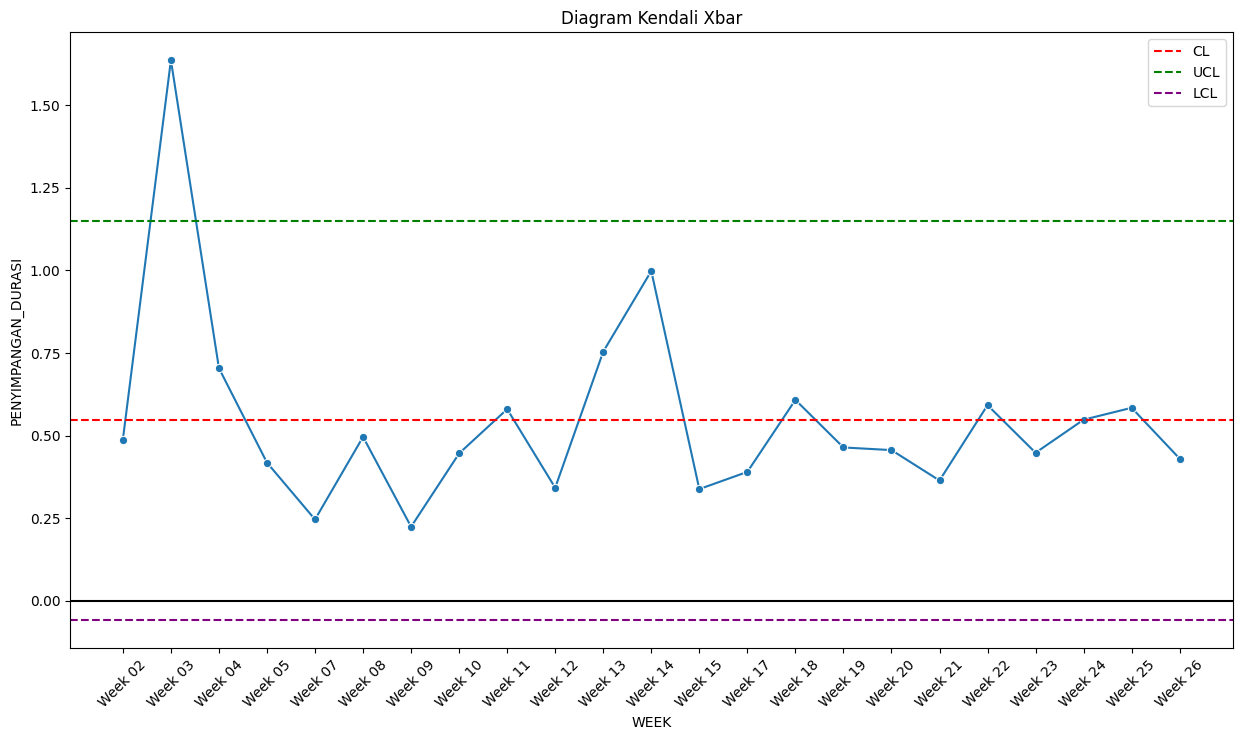

In [164]:
malam_e = shift_malam.copy()
malam_e.drop(malam_e.loc[malam_e["WEEK"].isin(["Week 01", "Week 06", "Week 16"])].index, inplace=True)
# siang_e.loc[siang_e["WEEK"].isin(["Week 01", "Week 14", "Week 20"]),'PENYIMPANGAN_DURASI'] = shift_siang['PENYIMPANGAN_DURASI'].mean()
chartx_malam, ucl, lcl, rbar,xbar = x_chart(malam_e)
plt.show()

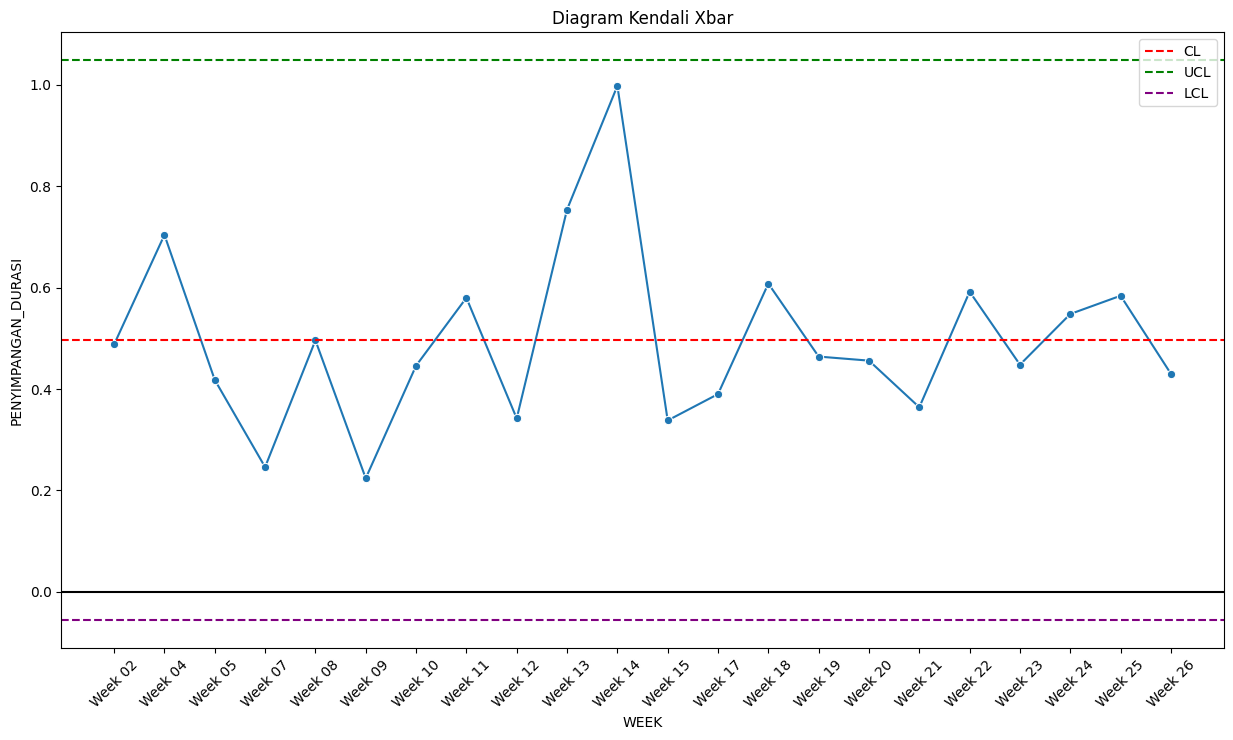

In [165]:
malam_e.drop(malam_e.loc[malam_e["WEEK"].isin(["Week 03"])].index, inplace=True)
# siang_e.loc[siang_e["WEEK"].isin(["Week 01", "Week 14", "Week 20"]),'PENYIMPANGAN_DURASI'] = shift_siang['PENYIMPANGAN_DURASI'].mean()
chartx_malam, ucl_malam, lcl_malam, rbar_malam,xbar_malam = x_chart(malam_e)
plt.show()

In [166]:
# cp_sore = (ucl_malam - lcl_malam)/((rbarm_awal/2.326)*6)
# cp_sore

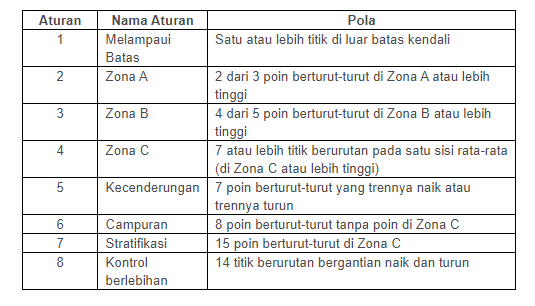

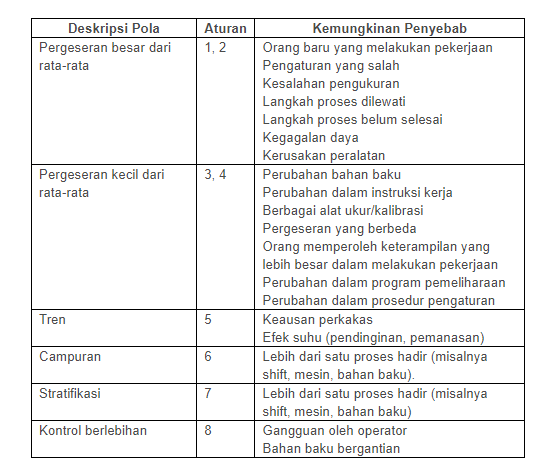

- Manusia  
  - Operator kurang teliti
  - Operator mengobrol ketika bekerja
  - Operator kelelahan ketika bekerja
- Mesin  
  - Mesin belum mendapatkan maintenance
  - Kondisi mesin / sparepart mesin yang buruk/rusak
- Material  
  - Perubahan kualitas bahan baku (karena suplier / umur bahan baku)
  - Penanganan bahan baku yang kurang bagus
- Proses  
  - Setting cetak yang tidak sesuai
  -
- Lingkungan  
  - Suhu ruangan mesin
  -


In [167]:
#Diagram Ishikawa

## Waste / Cetak Baik

In [168]:
#Diagram control


In [169]:
#Diagram Ishikawa

# Prediction

## Preprocessing

In [170]:
data.columns

Index(['SPK', 'MESIN', 'CUSTOMER', 'KATEGORI_MESIN', 'TANGGAL', 'OPLAH_MEDIA',
       'HASIL_CETAK', 'JUMLAH_BAHAN', 'SHIFT', 'JUMLAH_PENGGUNAAN',
       'DURASI_SETTING', 'DURASI_MESIN', 'ADA_TROUBLE', 'LAMA_TROUBLE',
       'ADA_WASTE', 'JUMLAH_WASTE', 'KATEGORI_CETAKAN', 'DURASI_REALISASI',
       'DURASI_RENCANA', 'PENYIMPANGAN_DURASI', '%PENYIMPANGAN', 'CETAK_BAIK',
       'KAT_OPLAH_MEDIA', 'KAT_HASIL_CETAK', 'KAT_DURASI_MESIN'],
      dtype='object')

In [171]:
feature = data.drop(['PENYIMPANGAN_DURASI','SPK','MESIN','TANGGAL','DURASI_REALISASI','DURASI_RENCANA','CETAK_BAIK','%PENYIMPANGAN'], axis=1)
target = data['PENYIMPANGAN_DURASI']

In [172]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, random_state=48)

print(X_train.shape)
print(y_train.shape)

(6751, 17)
(6751,)


In [173]:
X_train.columns

Index(['CUSTOMER', 'KATEGORI_MESIN', 'OPLAH_MEDIA', 'HASIL_CETAK',
       'JUMLAH_BAHAN', 'SHIFT', 'JUMLAH_PENGGUNAAN', 'DURASI_SETTING',
       'DURASI_MESIN', 'ADA_TROUBLE', 'LAMA_TROUBLE', 'ADA_WASTE',
       'JUMLAH_WASTE', 'KATEGORI_CETAKAN', 'KAT_OPLAH_MEDIA',
       'KAT_HASIL_CETAK', 'KAT_DURASI_MESIN'],
      dtype='object')

In [174]:
transformer = ColumnTransformer(transformers=[
    ('Encoding_OHE', OneHotEncoder(), ['CUSTOMER', 'KATEGORI_MESIN', 'KATEGORI_CETAKAN','SHIFT', 'ADA_WASTE', 'ADA_TROUBLE']),
    ('Robust_Scaling', RobustScaler(), X_train.select_dtypes('number').columns)
])

In [175]:
regression = Pipeline(steps=[
    ('Preprocessing',transformer),
    ('Feature_Selection',SelectFwe(score_func=f_regression, alpha=0.05)),
    ('Estimator',LinearRegression())
])

In [176]:
#Model List
model_list = [

    LinearRegression(),
    DecisionTreeRegressor(random_state=48),
    KNeighborsRegressor(),
    SVR(),
    Ridge(),
    Lasso()
]
param_space = {
    'Estimator':model_list
}

## Model Benchmarking

In [177]:
grid_search= GridSearchCV(
    estimator=regression,
    param_grid=param_space,
    cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)

In [178]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessing',
                                        ColumnTransformer(transformers=[('Encoding_OHE',
                                                                         OneHotEncoder(),
                                                                         ['CUSTOMER',
                                                                          'KATEGORI_MESIN',
                                                                          'KATEGORI_CETAKAN',
                                                                          'SHIFT',
                                                                          'ADA_WASTE',
                                                                          'ADA_TROUBLE']),
                                                                        ('Robust_Scaling',
                                                                         RobustScaler(),
                                                                         Index(['OPLAH_MEDIA', 'HASIL_CETAK', 'JUMLAH_BAHAN', 'JUMLAH_PENGGUNAAN',
       'DURASI_SETTING', 'DURASI_MESIN', 'LAMA_TROUBLE', 'JUMLAH_WASTE'],
      dtype='object'))])),
                                       ('Feature_Selection',
                                        SelectFwe(score_func=<function f_regression at 0x7996611bbd00>)),
                                       ('Estimator', LinearRegression())]),
             param_grid={'Estimator': [LinearRegression(),
                                       DecisionTreeRegressor(random_state=48),
                                       KNeighborsRegressor(), SVR(), Ridge(),
                                       Lasso()]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [179]:
grid_search.best_params_

{'Estimator': DecisionTreeRegressor(random_state=48)}

In [180]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1       0.087524      0.010812         0.014053        0.001690   
2       0.039655      0.008395         0.071327        0.026816   
5       0.041539      0.001937         0.014830        0.005738   
3       0.844301      0.188725         0.203276        0.047183   
4       0.037743      0.005626         0.012287        0.000533   

                          param_Estimator  \
1  DecisionTreeRegressor(random_state=48)   
2                   KNeighborsRegressor()   
5                                 Lasso()   
3                                   SVR()   
4                                 Ridge()   

                                              params  split0_test_score  \
1  {'Estimator': DecisionTreeRegressor(random_sta...          -0.629900   
2               {'Estimator': KNeighborsRegressor()}          -0.618437   
5                             {'Estimator': Lasso()}          -0.830556   
3                               {'Estimator': SVR()}          -0.896693   
4                             {'Estimator': Ridge()}          -1.014281   

   split1_test_score  split2_test_score  split3_test_score  ...  \
1          -0.471786          -0.710387          -0.959971  ...   
2          -0.536076          -0.987861          -0.780816  ...   
5          -0.834875          -1.076272          -1.053079  ...   
3          -0.542943          -1.448585          -1.086066  ...   
4          -0.951637          -1.231784          -1.100316  ...   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
1        -0.729234        0.173630                1           -0.002810   
2        -0.764029        0.168054                2           -0.620592   
5        -0.986759        0.128888                3           -1.065975   
3        -1.043786        0.309346                4           -1.056519   
4        -1.089676        0.098722                5           -1.261470   

   split1_train_score  split2_train_score  split3_train_score  \
1           -0.003507           -0.003268           -0.013217   
2           -0.604785           -0.608622           -0.599832   
5           -1.083576           -0.938578           -0.862558   
3           -1.129433           -0.908939           -0.988810   
4           -1.205062           -1.106899           -0.929776   

   split4_train_score  mean_train_score  std_train_score  
1           -0.009113         -0.006383         0.004121  
2           -0.539960         -0.594758         0.028245  
5           -0.974979         -0.985133         0.081880  
3           -1.010413         -1.018823         0.073078  
4           -0.957452         -1.092132         0.131259  

[5 rows x 21 columns]

## Hyperparameter Tuning

In [181]:
param_space_tuning = {
    'Estimator__criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'Estimator__max_depth':[10, 20, 30, None],
    'Estimator__min_samples_split':[2, 5, 10,15],
    'Estimator__min_samples_leaf':[1,2,5,10]
}

In [182]:
grid_search_tuning= GridSearchCV(
    estimator=grid_search.best_estimator_,
    param_grid=param_space_tuning,
    cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)

In [183]:
grid_search_tuning.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessing',
                                        ColumnTransformer(transformers=[('Encoding_OHE',
                                                                         OneHotEncoder(),
                                                                         ['CUSTOMER',
                                                                          'KATEGORI_MESIN',
                                                                          'KATEGORI_CETAKAN',
                                                                          'SHIFT',
                                                                          'ADA_WASTE',
                                                                          'ADA_TROUBLE']),
                                                                        ('Robust_Scaling',
                                                                         RobustScaler(),
                                                                         Index(['OPLAH_MEDIA', 'HASIL_CETAK', 'JUMLAH_BAHAN', 'JUMLAH_PENGGUNAAN',
       'DURASI_SETTING', 'DURASI_MESIN', 'LAMA_...
                                        SelectFwe(score_func=<function f_regression at 0x7996611bbd00>)),
                                       ('Estimator',
                                        DecisionTreeRegressor(random_state=48))]),
             param_grid={'Estimator__criterion': ['squared_error',
                                                  'friedman_mse',
                                                  'absolute_error', 'poisson'],
                         'Estimator__max_depth': [10, 20, 30, None],
                         'Estimator__min_samples_leaf': [1, 2, 5, 10],
                         'Estimator__min_samples_split': [2, 5, 10, 15]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [184]:
grid_search_tuning.best_params_

{'Estimator__criterion': 'absolute_error',
 'Estimator__max_depth': 20,
 'Estimator__min_samples_leaf': 5,
 'Estimator__min_samples_split': 2}

criterion : absolute_error  
max_depth : 30  
min_samples_leaf : 5  
min_samples_split : 2  

In [185]:
best_model = DecisionTreeRegressor(criterion = 'absolute_error',
                                   max_depth = 30,
                                   min_samples_leaf = 5,
                                   min_samples_split = 2,
                                   random_state=48)

In [186]:
X_transform = transformer.fit_transform(X_train)
X_transform = pd.DataFrame(X_transform,columns=transformer.get_feature_names_out())
X_transform

Encoding_OHE__CUSTOMER_Instansi Lain  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
...                                    ...   
6746                                   0.0   
6747                                   0.0   
6748                                   0.0   
6749                                   0.0   
6750                                   0.0   

      Encoding_OHE__CUSTOMER_Instansi Pemerintahan  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              1.0   
4                                              0.0   
...                                            ...   
6746                                           0.0   
6747                                           0.0   
6748                                           0.0   
6749                                           0.0   
6750                                           0.0   

      Encoding_OHE__CUSTOMER_Instansi Pendidikan  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   
...                                          ...   
6746                                         0.0   
6747                                         0.0   
6748                                         0.0   
6749                                         0.0   
6750                                         0.0   

      Encoding_OHE__CUSTOMER_Internal Temprina  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   
...                                        ...   
6746                                       0.0   
6747                                       0.0   
6748                                       0.0   
6749                                       0.0   
6750                                       0.0   

      Encoding_OHE__CUSTOMER_Jawa Pos  Encoding_OHE__CUSTOMER_Perorangan  \
0                                 0.0                                1.0   
1                                 1.0                                0.0   
2                                 1.0                                0.0   
3                                 0.0                                0.0   
4                                 0.0                                0.0   
...                               ...                                ...   
6746                              0.0                                0.0   
6747                              1.0                                0.0   
6748                              0.0                                0.0   
6749                              1.0                                0.0   
6750                              0.0                                1.0   

      Encoding_OHE__CUSTOMER_Perusahaan  \
0                                   0.0   
1                                   0.0   
2                                   0.0   
3                                   0.0   
4                                   1.0   
...                                 ...   
6746                                1.0   
6747                                0.0   
6748                                1.0   
6749                                0.0   
6750                                0.0   

      Encoding_OHE__KATEGORI_MESIN_Cetak Sheet  \
0                                          0.0   
1                                          0.0  

In [187]:
X_transform = pd.DataFrame(SelectFwe(score_func=f_regression, alpha=0.05).fit_transform(X_transform,y_train),
                           columns=SelectFwe(score_func=f_regression, alpha=0.05).fit(X_transform,y_train).get_feature_names_out(input_features=X_transform.columns))
X_transform

Encoding_OHE__CUSTOMER_Instansi Pemerintahan  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              1.0   
4                                              0.0   
...                                            ...   
6746                                           0.0   
6747                                           0.0   
6748                                           0.0   
6749                                           0.0   
6750                                           0.0   

      Encoding_OHE__CUSTOMER_Jawa Pos  Encoding_OHE__KATEGORI_MESIN_Cetak Web  \
0                                 0.0                                     1.0   
1                                 1.0                                     1.0   
2                                 1.0                                     1.0   
3                                 0.0                                     0.0   
4                                 0.0                                     1.0   
...                               ...                                     ...   
6746                              0.0                                     0.0   
6747                              1.0                                     0.0   
6748                              0.0                                     0.0   
6749                              1.0                                     0.0   
6750                              0.0                                     0.0   

      Encoding_OHE__KATEGORI_MESIN_Finishing  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   
...                                      ...   
6746                                     0.0   
6747                                     0.0   
6748                                     0.0   
6749                                     0.0   
6750                                     1.0   

      Encoding_OHE__KATEGORI_CETAKAN_kitab suci  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   
...                                         ...   
6746                                        0.0   
6747                                        0.0   
6748                                        0.0   
6749                                        0.0   
6750                                        0.0   

      Encoding_OHE__KATEGORI_CETAKAN_koran  \
0                                      0.0   
1                                      1.0   
2                                      1.0   
3                                      0.0   
4                                      1.0   
...                                    ...   
6746                                   0.0   
6747                                   1.0   
6748                                   1.0   
6749                                   1.0   
6750                                   0.0   

      Encoding_OHE__KATEGORI_CETAKAN_surat suara  Encoding_OHE__ADA_WASTE_Ada  \
0                                            0.0                          1.0   
1                                            0.0                          1.0   
2                                            0.0                          1.0   
3                                            1.0                          0.0   
4                                            0.0                          1.0   
...                                          ...                          ...   
6746                                         0.0                          

In [188]:
best_model.fit(X_transform,y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=30,
                      min_samples_leaf=5, random_state=48)

## Evaluation Best model

In [189]:
regression = Pipeline(steps=[
    ('Preprocessing',transformer),
    ('Feature_Selection',SelectFwe(score_func=f_regression, alpha=0.05)),
    ('Estimator',best_model)
])

In [190]:
regression.fit(X_train,y_train)
y_pred = regression.predict(X_test)
y_pred = pd.DataFrame(y_pred,columns=['Prediksi'])
y_pred

Prediksi
0      361.130
1        0.230
2        0.080
3        0.325
4        0.175
...        ...
2246     1.730
2247     0.680
2248     0.080
2249     0.250
2250     0.270

[2251 rows x 1 columns]

In [191]:
prediksi = pd.DataFrame()
prediksi['y_test'] = y_test.reset_index(drop=True)
prediksi['prediksi'] = y_pred
prediksi['residual'] = prediksi['prediksi'] - prediksi['y_test']
prediksi

y_test  prediksi  residual
0     361.13   361.130     0.000
1       0.23     0.230     0.000
2       0.23     0.080    -0.150
3       0.20     0.325     0.125
4       0.33     0.175    -0.155
...      ...       ...       ...
2246    1.02     1.730     0.710
2247    0.57     0.680     0.110
2248    0.08     0.080     0.000
2249    0.25     0.250     0.000
2250    0.32     0.270    -0.050

[2251 rows x 3 columns]

In [192]:
print(f'MAE = {mean_absolute_error(y_test,y_pred).round(2)}')
print(f'MAPE = {mean_absolute_percentage_error(y_test,y_pred).round(2)}')
print(f'MSE = {mean_squared_error(y_test,y_pred).round(2)}')
print(f'RMSE = {np.sqrt(mean_squared_error(y_test,y_pred)).round(2)}')
print(f'r2_score = {round(r2_score(y_test,y_pred),2)}')

MAE = 0.72
MAPE = 18756662153087.44
MSE = 20.02
RMSE = 4.47
r2_score = 0.92


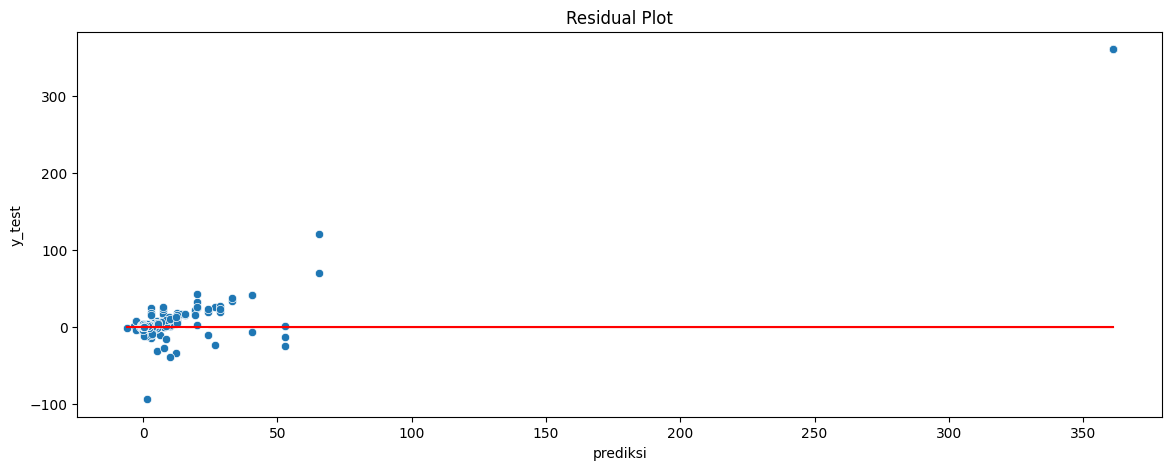

In [193]:
plt.figure(figsize=(14,5))
sns.scatterplot(data=prediksi, x='prediksi', y='y_test')
sns.lineplot(data=prediksi, x='prediksi', y=0, color='red')
plt.title('Residual Plot')
plt.show()

In [194]:
X_test.columns

Index(['CUSTOMER', 'KATEGORI_MESIN', 'OPLAH_MEDIA', 'HASIL_CETAK',
       'JUMLAH_BAHAN', 'SHIFT', 'JUMLAH_PENGGUNAAN', 'DURASI_SETTING',
       'DURASI_MESIN', 'ADA_TROUBLE', 'LAMA_TROUBLE', 'ADA_WASTE',
       'JUMLAH_WASTE', 'KATEGORI_CETAKAN', 'KAT_OPLAH_MEDIA',
       'KAT_HASIL_CETAK', 'KAT_DURASI_MESIN'],
      dtype='object')

In [195]:
from sklearn.tree import export_graphviz
import graphviz
export_graphviz(best_model, out_file ='tree_structure.dot', feature_names = X_transform.columns, max_depth=5, filled = True)


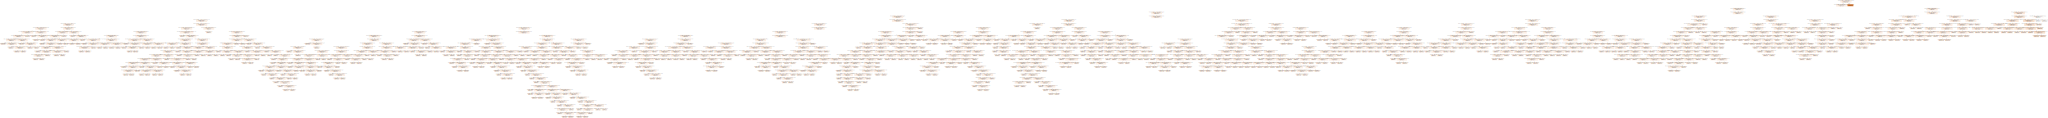

In [196]:
dot_data = export_graphviz(best_model, out_file=None,
                                feature_names=X_transform.columns,
                                filled=True)
dt_graph = graphviz.Source(dot_data, format="png")
# dt_graph.render("temp_img",format="png")
dt_graph

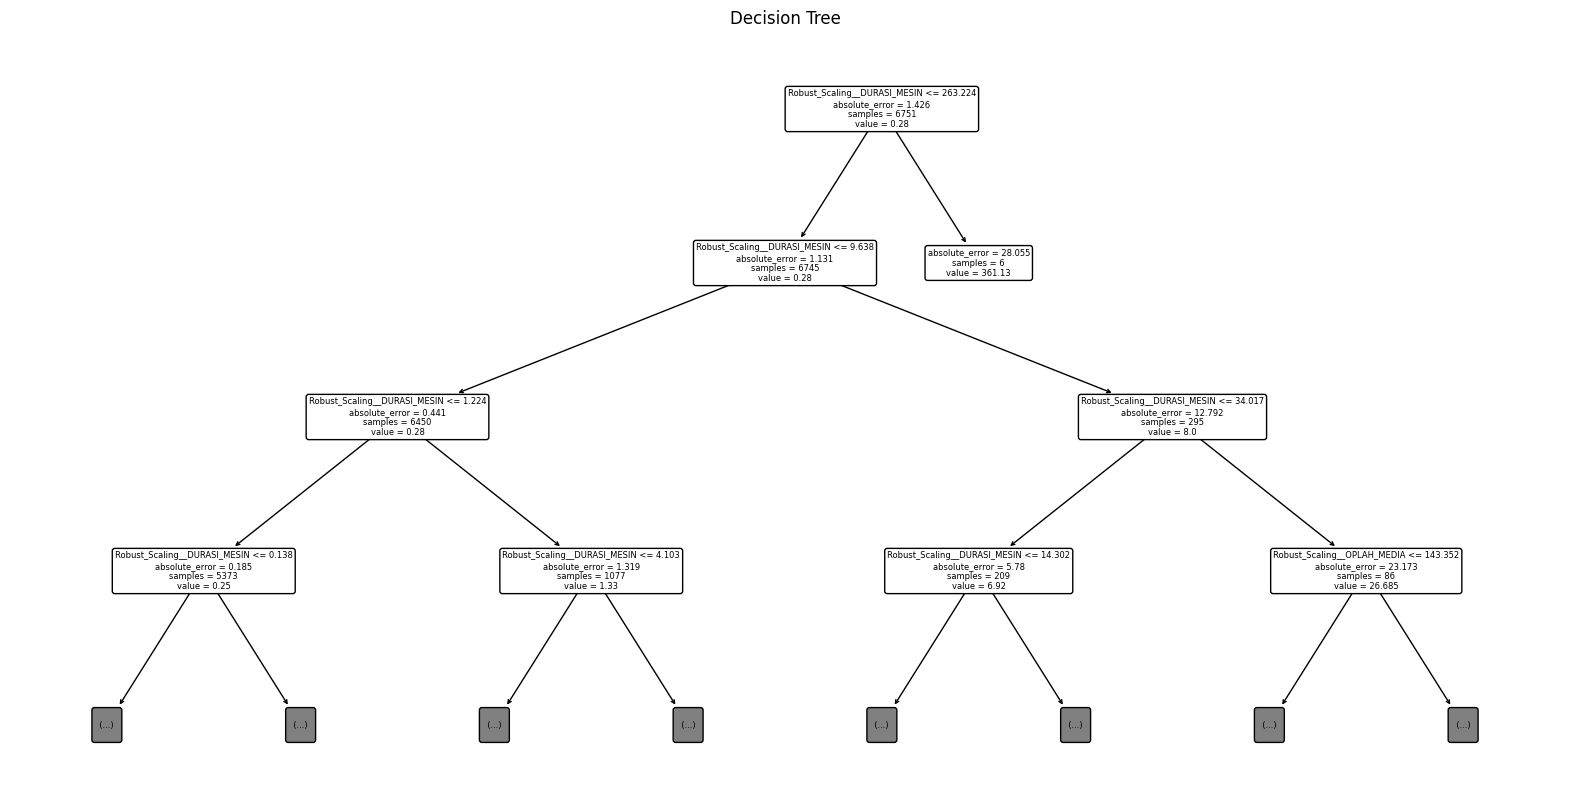

In [197]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
ax = plot_tree(best_model, max_depth=3, feature_names=X_transform.columns, rounded=True)
plt.title('Decision Tree')
# plt.savefig('decision tree.png', transparent=True)
plt.show()

In [198]:
nama_kolom = ['Customer Instansi Pemerintah','Customer Jawa Pos','Mesin Cetak Web','Mesin Cetak Finishing','Cetakan Kitab Suci', 'Cetakan Koran','Cetakan Surat Suara','Ada Waste','Tidak Ada Waste', 'Oplah Media', 'Jumlah Bahan', 'Jumlah Penggunaan', 'Durasi Setting', 'Durasi Mesin', 'Jumlah Waste' ]
tree_importances = best_model.feature_importances_
tree_importances = pd.DataFrame(tree_importances, index=nama_kolom, columns=['Importance'])
tree_importances = tree_importances.reset_index(names='Features').sort_values('Importance')
tree_importances.head()

Features  Importance
1    Customer Jawa Pos    0.000104
6  Cetakan Surat Suara    0.000109
7            Ada Waste    0.000250
8      Tidak Ada Waste    0.000270
2      Mesin Cetak Web    0.000600

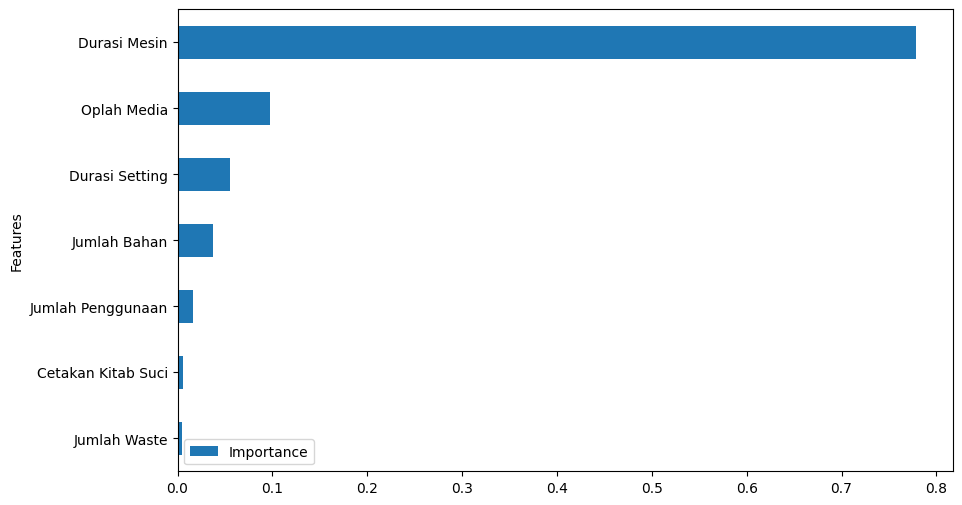

In [199]:
tree_importances.tail(7).plot(x='Features', y='Importance', kind='barh', figsize=(10, 6))
# plt.savefig('dt importance.png', transparent=True)
plt.show()

In [200]:
#Create shap explainer
explainer = shap.Explainer(best_model,
                           X_transform,
                           feature_names=nama_kolom)
#calculate shap value
shap_values = explainer(X_transform)

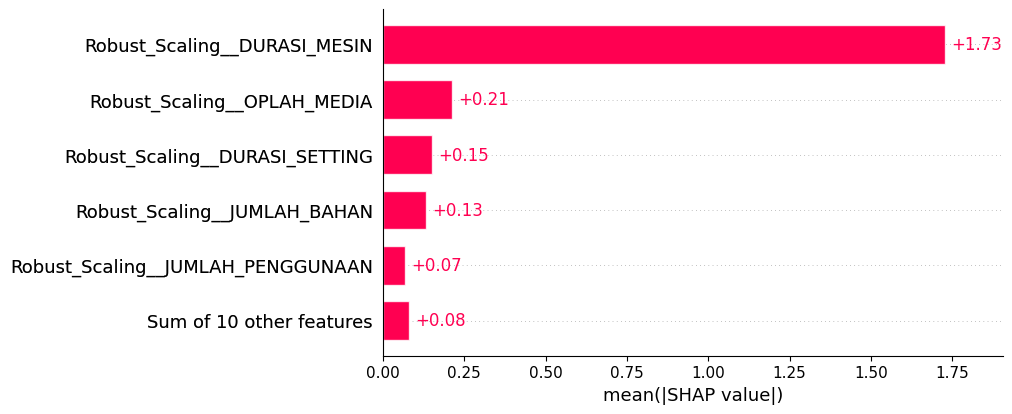

In [201]:
shap.plots.bar(shap_values, max_display=6)


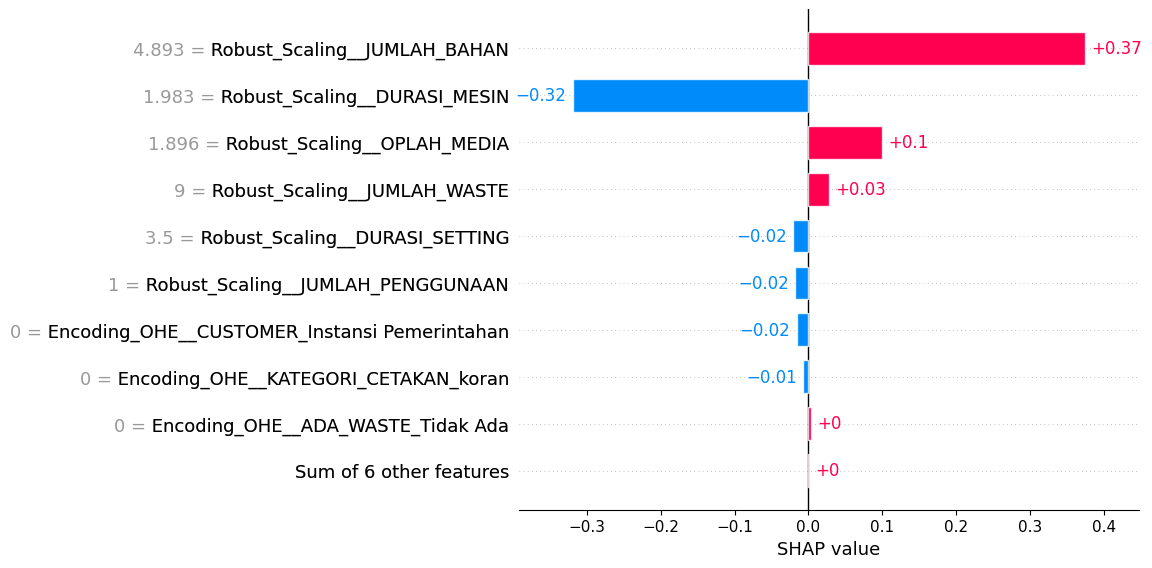

In [202]:
shap.plots.bar(shap_values[0])